# Homework 1


## What this repo contains

This repository contains statistics and charts on dataset for obesity. Here we performed univariate and multivariate analysis.

From the univariate analysis we can obtain the following details:
1. Age is leptokurtic and right skewed. This indicates that our dataset is quite targeted on a younger population.
1. Height and weight are mesokurtic and symmetric. This indicates that our dataset has a wide variation in its data.
1. Many of the surveyed individuals in the available dataset already present a family member that face this issue in their family, thus indicating that this also might be based on genetics.
1. Many of the surveyed individuals are frequently consuming high-caloric foods.

From the multivariate analysis we can obtain the following:
1. Based on scatter-plots (screenshot #1 below) and boxplots (screenshot #2, #3 below), the attributes with the highest prediction power are:
    1. Height
    1. Weight
    1. Age
1. Based on the ANOVA score (screenshot #4 below), we could also observe that FCVC (Frequency of consumption of vegetables) is inversely correlated with obesity, thus vegetarians _might_ be on the normal weight category.
1. Many of the surveyed individuals that consume foods with high calories don't smoke.
1. Many of the surveyed individuals that consume foods with high calories don't monitor their calories intake.
1. Many of the surveyed individuals that have low weight (and probably low height) are anorexic (source: stacked histograms). 

## Screenshots

### Screenshot #1: Scatter-plot based on height, weight, and obesity prediction

* The scatter plot displays that using Height and Weight, the data could be easily separable

![Height-weight scatterplot](./resources/heigh_weight_scatterplot.png)

### Screenshot #2: Boxplot based on weight and obesity prediction

* The boxplot shows that label variable separates the numerical attribute Weight quite well.

![Weight-obesity boxplot](./resources/weight_obesity_boxplot.png)

### Screenshot #3: Boxplot based on age and obesity prediction

* This boxplot helps us separate Obesity_Type_II and Obesity_Type_III using the Age attribute. Separating these 2 classes using just Weight attribute is more dificult.

![Age-obesity boxplot](./resources/age_obesity_boxplot.png)

### Screenshot #4: ANOVA score 

* The ANOVA test confirm what the plots above show us in regards to the Weight, Height and Age variables. Also, it shows that FCVC also has a good predictive power.

![ANOVA score](./resources/anova_score.png)

### Screenshot #4: CAEC, Gender, family_history_with_overweight, CALC

![Chi2 score](./resources/chi2_score.png)

* The CHI2 score shows that CAEC, Gender, family_history_with_overweight and CALC

## Dependencies

In [1]:
!pip install ipympl
!pip install plotly

In [2]:
import csv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import seaborn as sns
import typing as t
import numpy as np
import numpy.typing as npt
import itertools
import pandas as pd
from scipy import stats as scpy_stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import plotly
import plotly.graph_objs as go
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

plotly.offline.init_notebook_mode()
%matplotlib widget
%matplotlib inline

In [3]:
class Person:
    Gender: str
    Age: int
    Height: float
    Weight: float
    family_history_with_overweight: str
    FAVC: str
    FCVC: int
    NCP: int
    CAEC: str
    SMOKE: str
    CH2O: int
    SCC: str
    FAF: str
    TUE: int
    CALC: str
    MTRANS: str
    NObeyesdad: str

    def __init__(
        self,
        Gender: str,
        Age: int,
        Height: float,
        Weight: float,
        family_history_with_overweight: str,
        FAVC: str,
        FCVC: int,
        NCP: int,
        CAEC: str,
        SMOKE: str,
        CH2O: int,
        SCC: str,
        FAF: int,
        TUE: int,
        CALC: str,
        MTRANS: str,
        NObeyesdad: str,
    ):
        self.Gender = Gender
        self.Age = Age
        self.Height = Height
        self.Weight = Weight
        self.family_history_with_overweight = family_history_with_overweight
        self.FAVC = FAVC
        self.FCVC = FCVC
        self.NCP = NCP
        self.CAEC = CAEC
        self.SMOKE = SMOKE
        self.CH2O = CH2O
        self.SCC = SCC
        self.FAF = FAF
        self.TUE = TUE
        self.CALC = CALC
        self.MTRANS = MTRANS
        self.NObeyesdad = NObeyesdad

    def __str__(self):
        return (
            "{"
            + f'"Gender": "{self.Gender}",'
            + f'"Age": {self.Age},'
            + f'"Height": {self.Height},'
            + f'"Weight": {self.Weight},'
            + f'"family_history_with_overweight": "{self.family_history_with_overweight}",'
            + f'"FAVC": "{self.FAVC}",'
            + f'"FCVC": {self.FCVC},'
            + f'"NCP": {self.NCP},'
            + f'"CAEC": "{self.CAEC}",'
            + f'"SMOKE": "{self.SMOKE}",'
            + f'"CH2O": {self.CH2O},'
            + f'"SCC": {self.SCC},'
            + f'"FAF": "{self.FAF}",'
            + f'"TUE": {self.TUE},'
            + f'"CALC": "{self.CALC}",'
            + f'"MTRANS": "{self.MTRANS}",'
            + f'"NObeyesdad": "{self.NObeyesdad}"'
            + "}"
        )

    def __len__(self):
        return 17

    __repr__ = __str__

In [4]:
NUMERICAL_VARIABLES = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
CATEGORICAL_VARIABLES = ["FAVC", "CAEC", "CALC", "SCC", "MTRANS", "Gender", "family_history_with_overweight", "SMOKE", "NObeyesdad"]

CATEGORICAL_VARIABLES_NO_LABEL = ["FAVC", "CAEC", "CALC", "SCC", "MTRANS", "Gender", "family_history_with_overweight", "SMOKE"]

LABEL_VARIABLE = "NObeyesdad"

In [5]:
class DatasetManager:
    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

    def load_as_obj_list(self) -> list[Person]:
        with open(self.path_to_csv) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            return [Person(**row) for row in csv_reader]

    @staticmethod
    def obj_list_to_dataseries(
        data: list[Person],
        attrs_list: list[str] = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES,
    ) -> t.List[t.List[np.float32]]:
        return [
            [np.float32(getattr(entry, field)) for entry in data]
            for field in attrs_list
        ]

    @staticmethod
    def obj_list_to_flat_np_array(
        data: list[Person],
        attrs_list: list[str] = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES,
    ) -> npt.NDArray[np.float32]:
        return np.array(
            [
                np.float32(getattr(entry, field))
                for entry in data
                for field in attrs_list
            ]
        )

    @staticmethod
    def obj_list_to_list(
        data: t.List[Person], attrs_list: t.List[str] = CATEGORICAL_VARIABLES
    ) -> t.List[t.List[str]]:
        return [[getattr(entry, field) for entry in data] for field in attrs_list]

    @staticmethod
    def obj_list_to_flat_list(
        data: t.List[Person], attrs_list: t.List[str] = CATEGORICAL_VARIABLES
    ) -> t.List[str]:
        return [getattr(entry, field) for field in attrs_list for entry in data]

    @staticmethod
    def make_combinations(
        attrs_list: t.List[str], k: int = 2
    ) -> t.List[t.Tuple[str, ...]]:
        return [subset for subset in itertools.combinations(attrs_list, k)]

    def obj_list_to_np_array(
        data: list[Person],
        attrs_list: list[str] = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES,
    ) -> np.array:
        return np.array(
            [[getattr(entry, field) for field in attrs_list] for entry in data]
        )

    @staticmethod
    def obj_list_to_np_array_numeric(
        data: list[Person],
        attrs_list: list[str] = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES,
    ) -> np.array:
        return DatasetManager.obj_list_to_np_array(data, attrs_list).astype(np.float64)

    @staticmethod
    def obj_list_to_np_array_category(
        data: list[Person],
        attrs_list: list[str] = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES,
    ) -> np.array:
        data_pd = pd.DataFrame(DatasetManager.obj_list_to_np_array(data, attrs_list))
        return np.vstack([pd.factorize(data_pd[col])[0] for col in data_pd.columns]).T

    @staticmethod
    def obj_list_to_np_array_category_binary(
        data: list[Person], attrs_list: list[str]
    ) -> np.array:
        data_pd = pd.DataFrame(DatasetManager.obj_list_to_np_array(data, attrs_list))
        return pd.get_dummies(data_pd).to_numpy().astype(np.float64)

    @staticmethod
    def object_list_to_pd_dataframe_category(
        data: list[Person], attr: str
    ) -> pd.Series:
        return pd.DataFrame(
            DatasetManager.obj_list_to_np_array(data, [attr])
        ).value_counts()

    @staticmethod
    def object_list_to_pd_dataframe_contingency_table(
        data: list[Person], lh_attr: str, rh_attr: str
    ) -> pd.DataFrame:
        data_pd = pd.DataFrame(
            DatasetManager.obj_list_to_np_array(data, [lh_attr, rh_attr]),
            columns=[lh_attr, rh_attr],
        )
        return pd.crosstab(data_pd[lh_attr], data_pd[rh_attr], margins=False)

    @staticmethod
    def get_numerical_for_each_category(
        data: list[Person], numerical_attr: str, categorical_attr: str
    ) -> list[tuple[np.array, str]]:

        data_np = DatasetManager.obj_list_to_np_array(
            data, [numerical_attr, categorical_attr]
        )
        unique_CATEGORICAL_VARIABLES = np.unique(data_np[:, 1]).tolist()

        return [
            (data_np[data_np[:, 1] == unique_val, 0].astype(np.float64), unique_val)
            for unique_val in unique_CATEGORICAL_VARIABLES
        ]

In [6]:
dataset_manager = DatasetManager("data/ObesityDataSet.csv")
dataset_obj_list = dataset_manager.load_as_obj_list()

## Univariate analysis

The following will be applied:
1. central tendency
1. spread
1. distribution form (skewness, kurtosis)
1. frequency of categorical data
1. graphs
    1. histograms
    1. density
    1. boxplots

### 1. Central tendency

Calculates mean, median and mode for each data series.

In [7]:
def calculate_central_tendency_numerical(
    np_dataset: np.array,
) -> t.Tuple[float, float, float]:
    mean = np.mean(np_dataset)
    median = np.median(np_dataset)
    mode = scpy_stats.mode(np_dataset).mode

    return mean, median, mode

In [8]:
for numerical_var in NUMERICAL_VARIABLES:
    dataset_for_numerical_val = DatasetManager.obj_list_to_flat_np_array(
        dataset_obj_list, [numerical_var]
    )

    mean, median, mode = calculate_central_tendency_numerical(dataset_for_numerical_val)

    print(f"On numerical var {numerical_var}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Mode: {mode}\n{['-' * 10]}")
    # MODE nu cred ca e si la variabile numerice

On numerical var Age
Mean: 24.312599182128906
Median: 22.777889251708984
Mode: 18.0
['----------']
On numerical var Height
Mean: 1.7016774415969849
Median: 1.7004990577697754
Mode: 1.7000000476837158
['----------']
On numerical var Weight
Mean: 86.58605194091797
Median: 83.0
Mode: 80.0
['----------']
On numerical var FCVC
Mean: 2.4190428256988525
Median: 2.3855020999908447
Mode: 3.0
['----------']
On numerical var NCP
Mean: 2.6856281757354736
Median: 3.0
Mode: 3.0
['----------']
On numerical var CH2O
Mean: 2.0080113410949707
Median: 2.0
Mode: 2.0
['----------']
On numerical var FAF
Mean: 1.0102977752685547
Median: 1.0
Mode: 0.0
['----------']
On numerical var TUE
Mean: 0.6578659415245056
Median: 0.6253499984741211
Mode: 0.0
['----------']


### 2. Spread

Calculates the spread of data for each data series. Useful to know wether the data has a "central tendency".

In [9]:
def calculate_spread_numerical(np_dataset: np.array) -> t.Tuple[float, float, float]:
    dataset_range = np.ptp(np_dataset)
    dataset_variance = np.var(np_dataset)
    dataset_standard_deviation = np.std(np_dataset)

    return dataset_range, dataset_variance, dataset_standard_deviation

In [10]:
for numerical_var in NUMERICAL_VARIABLES:
    dataset_for_numerical_val = DatasetManager.obj_list_to_flat_np_array(
        dataset_obj_list, [numerical_var]
    )
    dataset_range, dataset_variance, dataset_standard_deviation = (
        calculate_spread_numerical(dataset_for_numerical_val)
    )

    print(f"On numerical var {numerical_var}")
    print(f"Range: {dataset_range}")
    print(f"Variance: {dataset_variance}")
    print(f"Standard deviation: {dataset_standard_deviation}")
    print(f"{['-' * 10]}")

On numerical var Age
Range: 47.0
Variance: 40.252235412597656
Standard deviation: 6.3444647789001465
['----------']
On numerical var Height
Range: 0.5299999713897705
Variance: 0.008701666258275509
Standard deviation: 0.09328272193670273
['----------']
On numerical var Weight
Range: 134.0
Variance: 685.6525268554688
Standard deviation: 26.184967041015625
['----------']
On numerical var FCVC
Range: 2.0
Variance: 0.2849425971508026
Standard deviation: 0.5338001251220703
['----------']
On numerical var NCP
Range: 3.0
Variance: 0.6050573587417603
Standard deviation: 0.777854323387146
['----------']
On numerical var CH2O
Range: 2.0
Variance: 0.37553396821022034
Standard deviation: 0.6128082871437073
['----------']
On numerical var FAF
Range: 3.0
Variance: 0.7231647968292236
Standard deviation: 0.8503909707069397
['----------']
On numerical var TUE
Range: 2.0
Variance: 0.37061673402786255
Standard deviation: 0.6087830066680908
['----------']


### 3. Skewness, kurtosis

Calculates skewness and kurtosis of the dataset.

Meaning for skewness:
* Positively skewed (right-skewed):
    * The distribution is positively skewed **if the distribution's tail on the right side is longer or "fatter" than the left side**. This means that there are more data points on the left side, and the distribution as a longer right tail.
    * Values: `> 1`
* Negatively skewed (left-skewed):
    * The distribution is negatively skewed **if the distribution's tail on the left side is longer or "fatter" than the right side**. This means that there are more data points on the right side, and the distribution as a longer left tail.
    * Values: `< -1`
* Symmetric: 
    * If the distribution is _roughly_ the same on both sides, it is symmetric, and the skewness is close to 0.
    * Values: `~ 0`

Meaning of kurtosis:
* Mesokurtic (Normal distribution):
    * A distribution with kurtosis similar to that of a normal distribution
    * Values: `~ 0`
* Leptokurtic:
    * A distribution with pisitive kurtosis, indicating heavier tails and a more peaked central region compared to a normal distribution
    * Values: `> 1`
* Platykurtic:
    * A normal distribution with a negative kurtosis, indicating lighter tails and a flatter central region compared to a normal distribution
    * Values: `< -1`

In [11]:
def calculate_skewness_kurtosis_numerical(
    np_dataset: np.array,
) -> t.Tuple[float, float]:
    dataset_skewness = scpy_stats.skew(np_dataset)
    dataset_kurtosis = scpy_stats.kurtosis(np_dataset)

    return dataset_skewness, dataset_kurtosis

In [12]:
for numerical_var in NUMERICAL_VARIABLES:
    dataset_for_numerical_val = DatasetManager.obj_list_to_flat_np_array(
        dataset_obj_list, [numerical_var]
    )
    dataset_skewness, dataset_kurtosis = calculate_skewness_kurtosis_numerical(
        dataset_for_numerical_val
    )

    print(f"On numerical var {numerical_var}")
    print(f"Skewness: {dataset_skewness}")
    print(f"Kurtosis: {dataset_kurtosis}")
    print(f"{['-' * 10]}\n")

On numerical var Age
Skewness: 1.5280142589581394
Kurtosis: 2.8168588574298665
['----------']

On numerical var Height
Skewness: -0.012848459164393682
Kurtosis: -0.5644577300848859
['----------']

On numerical var Weight
Skewness: 0.2552297058507633
Kurtosis: -0.7010823664264967
['----------']

On numerical var FCVC
Skewness: -0.4325967095068614
Kurtosis: -0.6388791385493944
['----------']

On numerical var NCP
Skewness: -1.1063109919189047
Kurtosis: 0.38177433951646744
['----------']

On numerical var CH2O
Skewness: -0.10483672396474479
Kurtosis: -0.8801543419699018
['----------']

On numerical var FAF
Skewness: 0.4981349859683153
Kurtosis: -0.6219600181728873
['----------']

On numerical var TUE
Skewness: 0.6180627956587121
Kurtosis: -0.5502024431375689
['----------']



### 4. Frequency of categorical data

Here we count how often we see the categorical data in a data series.

In [13]:
def calculate_frequency_of_data_categorical(dataset: t.List[str]) -> t.Dict[str, int]:
    counts = {}

    for entry in dataset:
        if entry in counts:
            counts[entry] += 1
        else:
            counts[entry] = 1

    return counts

In [14]:
for categorical_var in CATEGORICAL_VARIABLES:
    dataset_for_categorical_val = DatasetManager.obj_list_to_flat_list(
        dataset_obj_list, [categorical_var]
    )
    dataset_frequency = calculate_frequency_of_data_categorical(
        dataset_for_categorical_val
    )

    print(f"On categorical var {categorical_var}")

    for entry in dataset_frequency:
        print(f'Frequency of value "{entry}": {dataset_frequency[entry]}')

    print(f"{['-' * 10]}")

On categorical var FAVC
Frequency of value "no": 245
Frequency of value "yes": 1866
['----------']
On categorical var CAEC
Frequency of value "Sometimes": 1765
Frequency of value "Frequently": 242
Frequency of value "Always": 53
Frequency of value "no": 51
['----------']
On categorical var CALC
Frequency of value "no": 639
Frequency of value "Sometimes": 1401
Frequency of value "Frequently": 70
Frequency of value "Always": 1
['----------']
On categorical var SCC
Frequency of value "no": 2015
Frequency of value "yes": 96
['----------']
On categorical var MTRANS
Frequency of value "Public_Transportation": 1580
Frequency of value "Walking": 56
Frequency of value "Automobile": 457
Frequency of value "Motorbike": 11
Frequency of value "Bike": 7
['----------']
On categorical var Gender
Frequency of value "Female": 1043
Frequency of value "Male": 1068
['----------']
On categorical var family_history_with_overweight
Frequency of value "yes": 1726
Frequency of value "no": 385
['----------']
On 

### 5. Graphs

Here we can find histograms, density charts and boxplots.

#### 5.1. Histograms

Histograms plot how frequently we meet a data entry from the dataset.

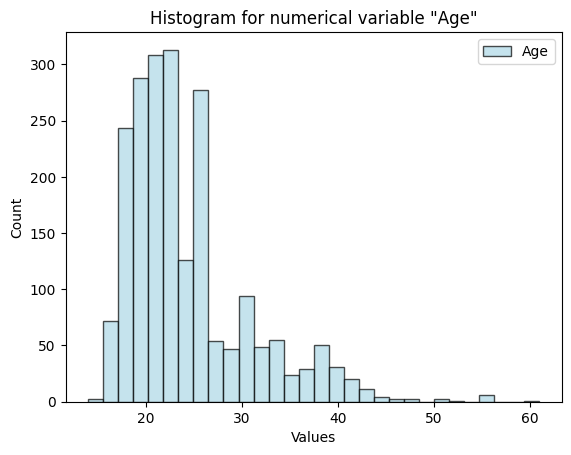

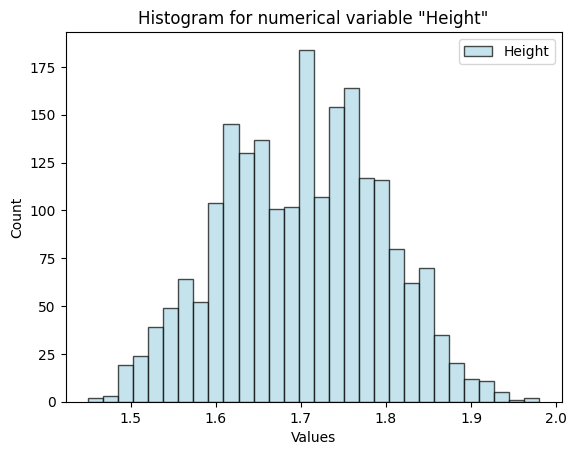

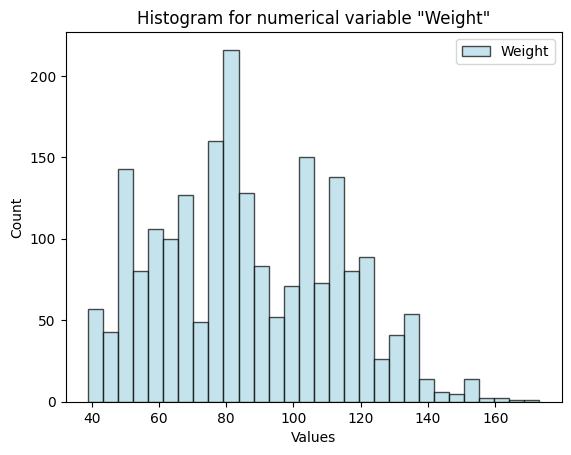

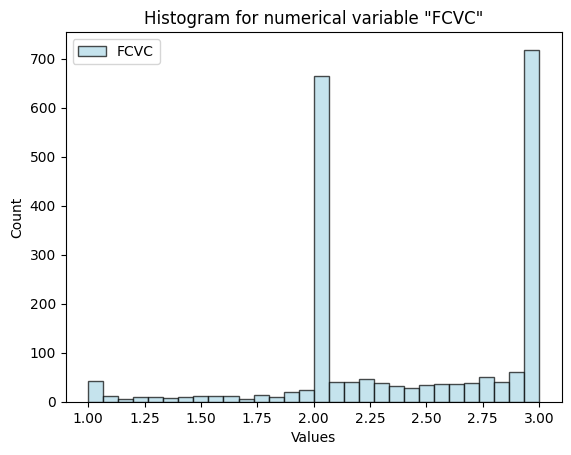

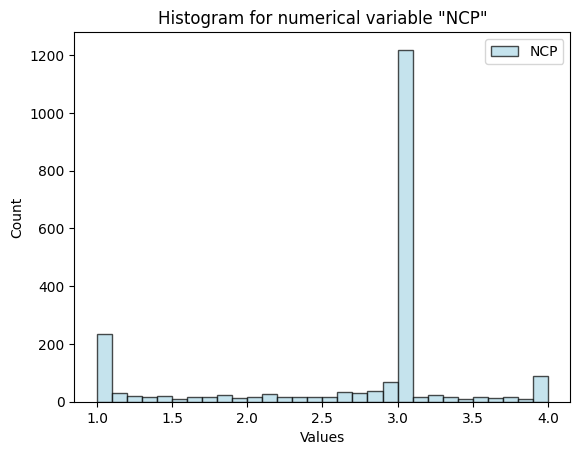

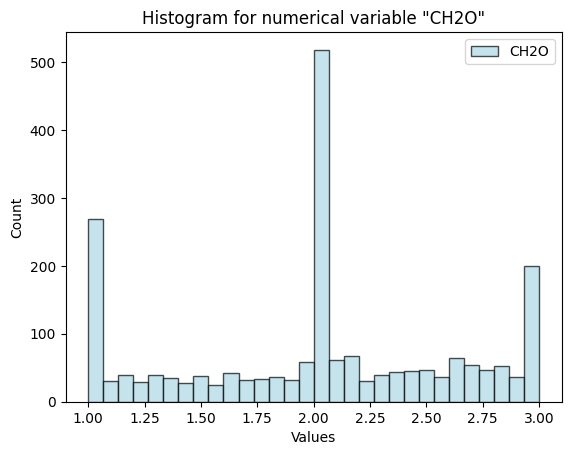

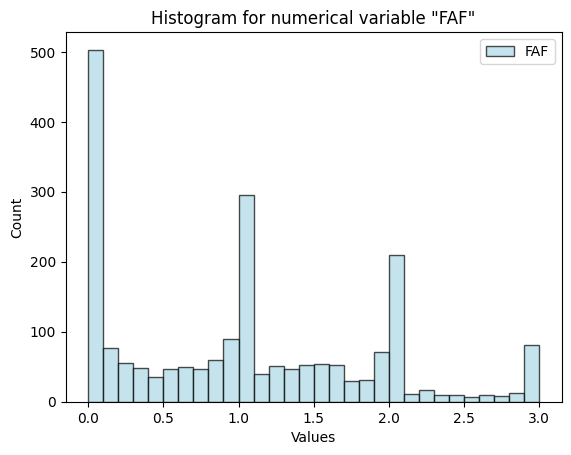

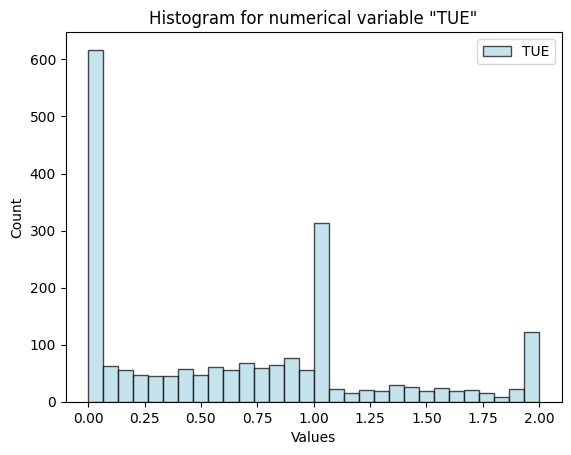

In [15]:
for numerical_var in NUMERICAL_VARIABLES:
    dataset_for_numerical_val = DatasetManager.obj_list_to_flat_np_array(
        dataset_obj_list, [numerical_var]
    )

    plt.figure()
    plt.hist(
        dataset_for_numerical_val,
        bins=30,
        color="lightblue",
        edgecolor="black",
        alpha=0.7,
        label=[numerical_var],
    )
    plt.title(f'Histogram for numerical variable "{numerical_var}"')
    plt.xlabel("Values")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

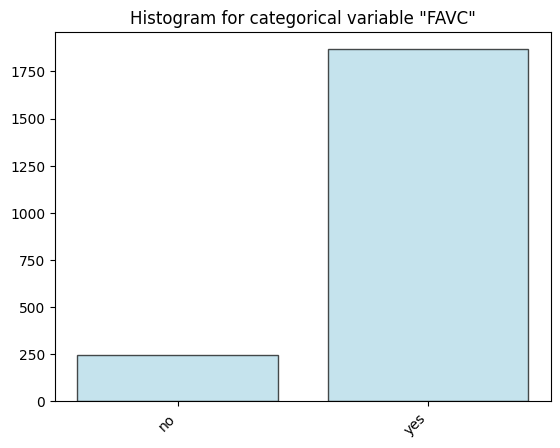

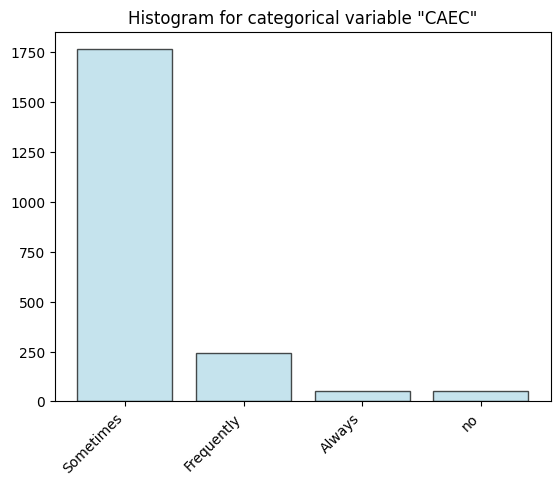

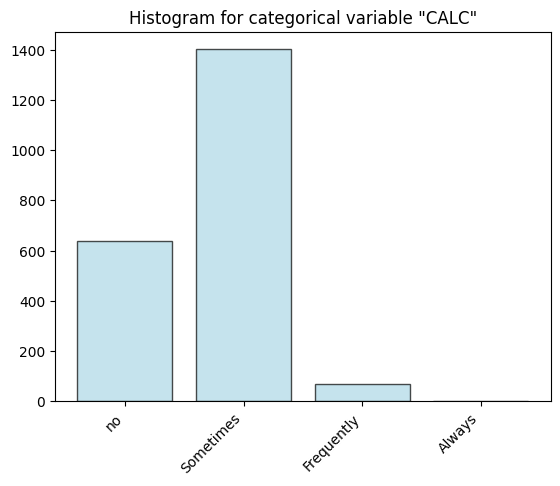

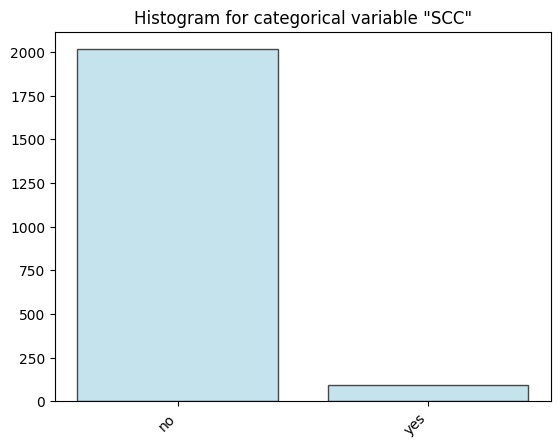

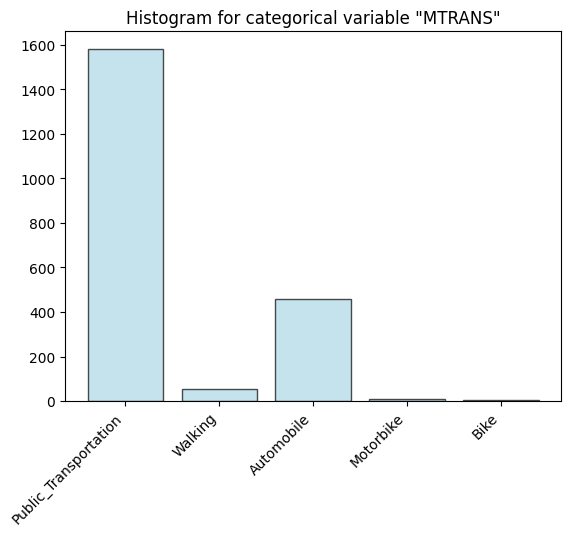

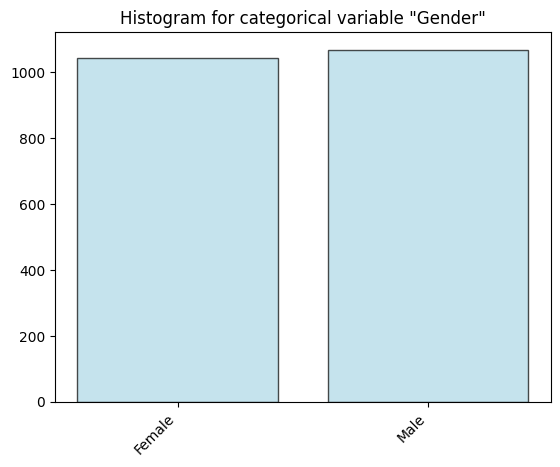

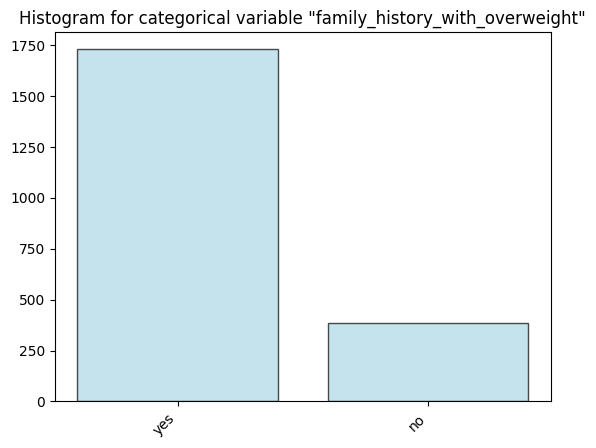

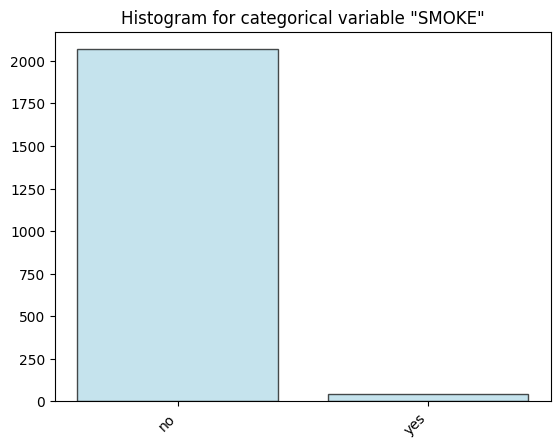

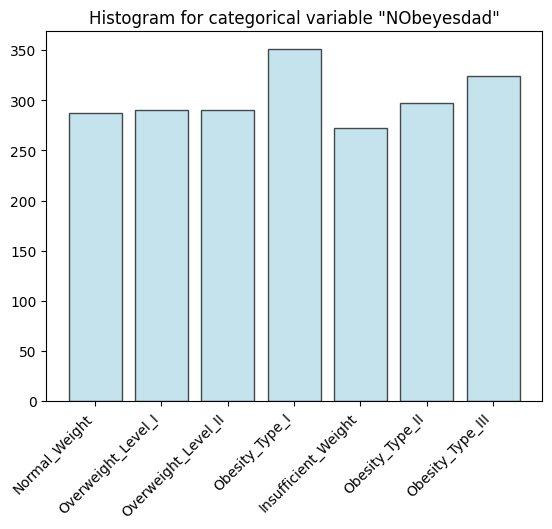

In [54]:
for categorical_var in CATEGORICAL_VARIABLES:
    dataset_for_categorical_val = DatasetManager.obj_list_to_flat_list(
        dataset_obj_list, [categorical_var]
    )

    dataset_frequency = calculate_frequency_of_data_categorical(
        dataset_for_categorical_val
    )
    dataset_keys = [key for key in dataset_frequency]
    dataset_values = [dataset_frequency[key] for key in dataset_frequency]

    plt.figure()
    plt.bar(
        dataset_keys, dataset_values, color="lightblue", edgecolor="black", alpha=0.7
    )
    plt.xticks(range(len(dataset_keys)), dataset_keys, rotation=45, ha="right")
    plt.title(f'Histogram for categorical variable "{categorical_var}"')
    plt.show()

#### 5.2. Density charts

Density charts plot how frequently we meet a data entry from the dataset and what distribution they follow.

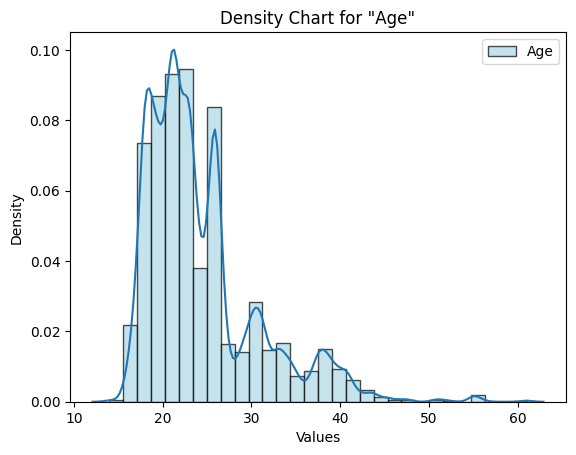

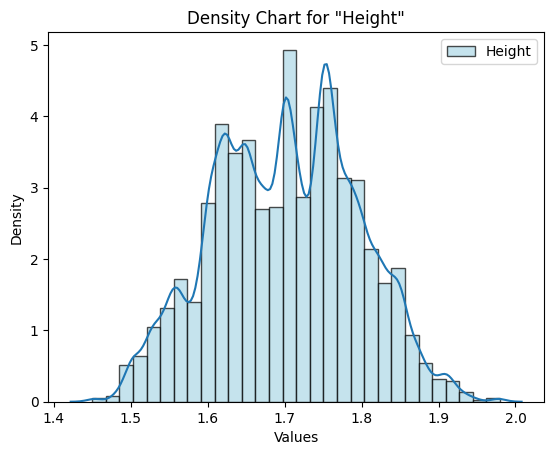

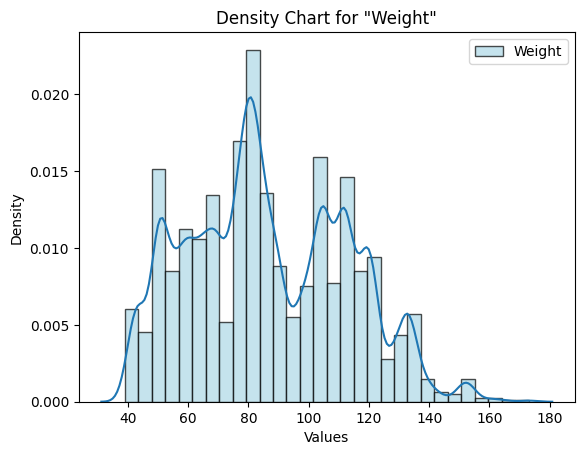

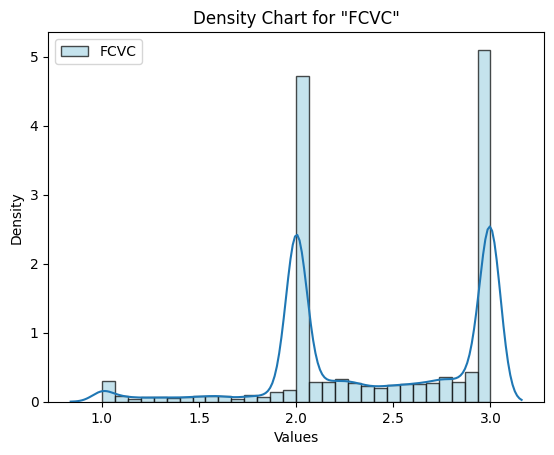

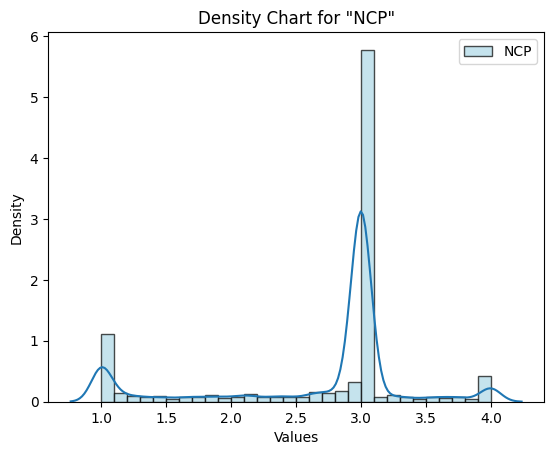

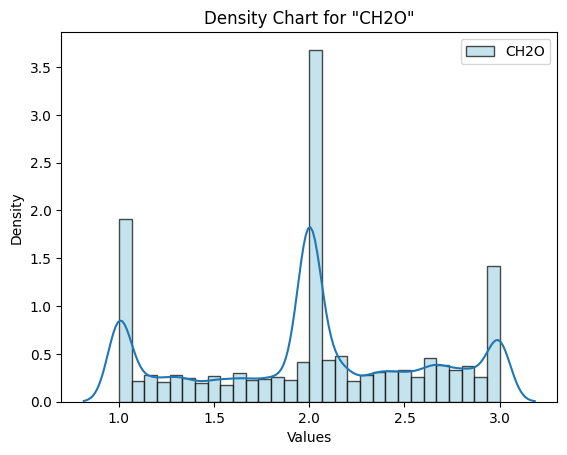

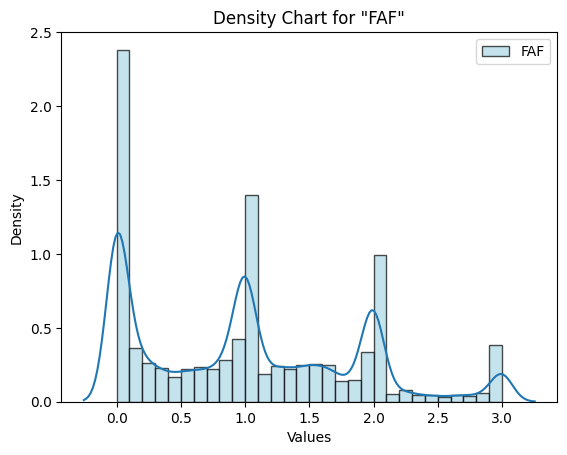

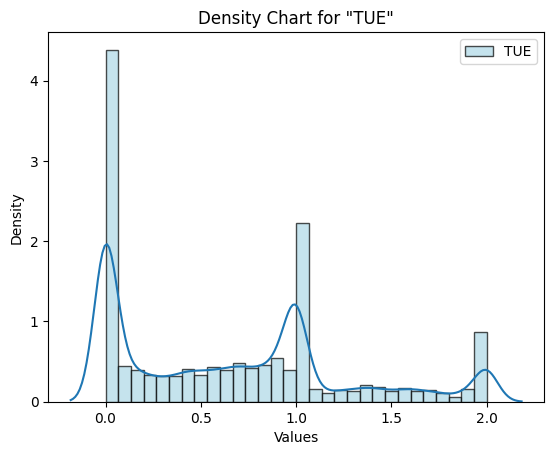

In [17]:
for numerical_var in NUMERICAL_VARIABLES:
    dataset_for_numerical_val = DatasetManager.obj_list_to_flat_np_array(
        dataset_obj_list, [numerical_var]
    )

    plt.figure()
    sns.kdeplot(dataset_for_numerical_val, bw=0.1)
    plt.hist(
        dataset_for_numerical_val,
        bins=30,
        density=True,
        color="lightblue",
        edgecolor="black",
        alpha=0.7,
        label=[numerical_var],
    )
    plt.title(f'Density Chart for "{numerical_var}"')
    plt.xlabel("Values")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

#### 5.3. Boxplots

Boxplots charts show how the data "behaves":
* min
* max
* quantiles
* outliers
* median
* inter-quartile range (contains 50% of the data)
* Skewness of data
* Robustness to extreme values
* etc.

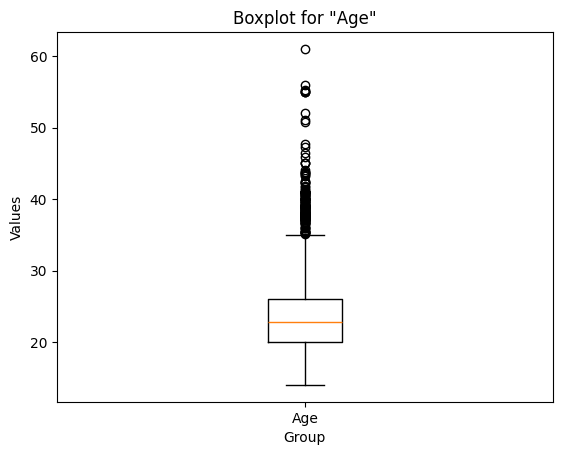

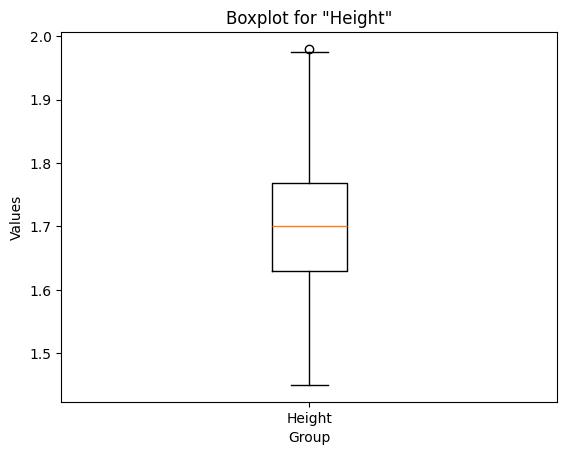

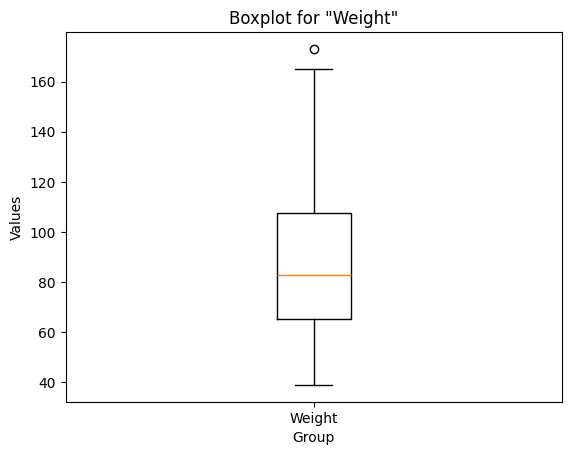

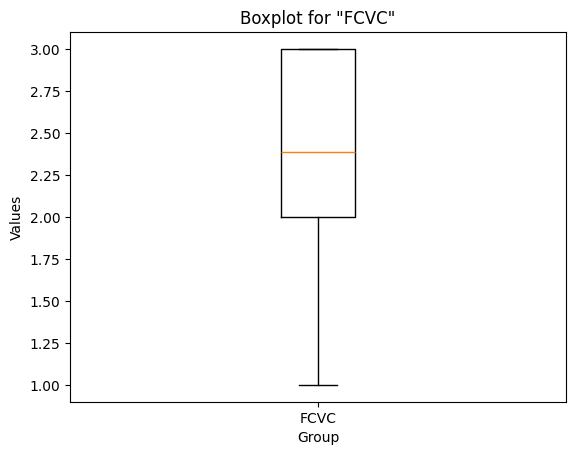

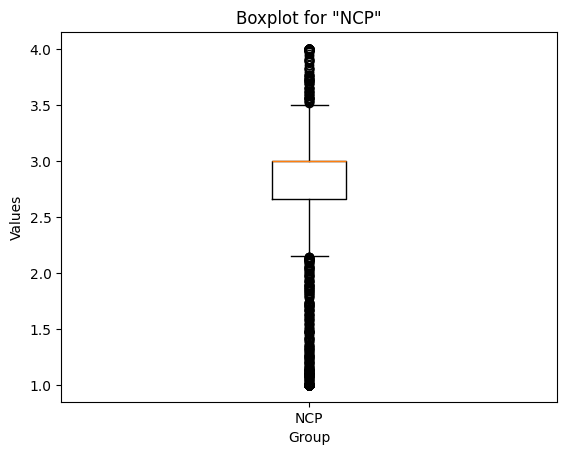

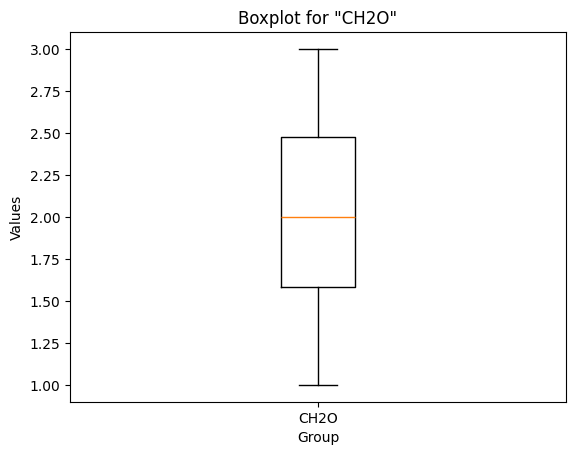

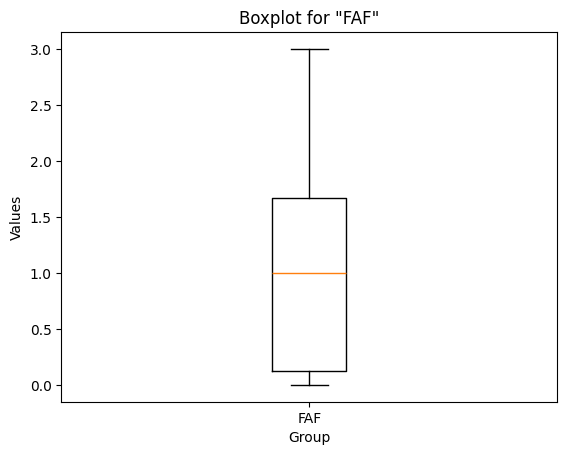

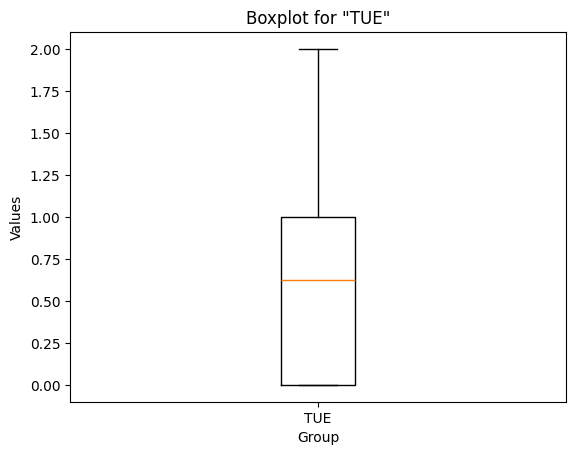

In [18]:
for numerical_var in NUMERICAL_VARIABLES:
    dataset_for_numerical_val = DatasetManager.obj_list_to_flat_np_array(
        dataset_obj_list, [numerical_var]
    )

    plt.figure()
    plt.boxplot(dataset_for_numerical_val, labels=[numerical_var])
    plt.xlabel("Group")
    plt.ylabel("Values")
    plt.title(f'Boxplot for "{numerical_var}"')
    plt.show()

## Multivariate analysis

The following will be applied:
1. Find Pearson Correlation and Spearman (Rank) correlation
1. Phi squared test, Fisher test and contingency tables
1. T Test (Testul Mediilor), Z Test, ANOVA Test
1. PCA in 2D si 3D; TSNE in 2d si 3D; Both using numerical + categorial
1. Projections using "Projection pursuit" methodologies
1. Stacked histograms
1. Corrgrams

In [19]:
numeric_numeric_correlation_indexes: dict[tuple[str, str], float] = dict()
categorial_categorial_correlation_indexes: dict[tuple[str, str], float] = dict()
categorial_numeric_t_correlation_indexes: dict[tuple[str, str], float] = dict()
categorial_numeric_anova_correlation_indexes: dict[tuple[str, str], float] = dict()

### 1. Find Pearson Correlation and Spearman (Rank) correlation

In [20]:
pearson_correlation: list[tuple[str, str, float]] = []
rank_correlation: list[tuple[str, str, float]] = []

for it in range(len(NUMERICAL_VARIABLES) - 1):
    for jt in range(it + 1, len(NUMERICAL_VARIABLES)):
        lh_var, rh_var = NUMERICAL_VARIABLES[it], NUMERICAL_VARIABLES[jt]

        lh_dataset = DatasetManager.obj_list_to_np_array_numeric(dataset_obj_list, [lh_var]).reshape(-1)

        rh_dataset = DatasetManager.obj_list_to_np_array_numeric(dataset_obj_list, [rh_var]).reshape(-1)

        pearson_cr = scpy_stats.pearsonr(lh_dataset, rh_dataset).correlation
        rank_cr = scpy_stats.spearmanr(lh_dataset, rh_dataset).correlation

        numeric_numeric_correlation_indexes[(lh_var, rh_var)] = pearson_cr

        pearson_correlation.append((lh_var, rh_var, pearson_cr))
        rank_correlation.append((lh_var, rh_var, rank_cr))

In [21]:
pearson_correlation = list(sorted(pearson_correlation, key=lambda x: x[2]))
print(f"Pearson Correlation\n\n")
for item in pearson_correlation:
    print(f"{item}\n")

Pearson Correlation


('Age', 'TUE', -0.29693059206832395)

('Age', 'FAF', -0.14493832661742817)

('FCVC', 'TUE', -0.10113484623419644)

('Weight', 'TUE', -0.07156135896003547)

('Weight', 'FAF', -0.05143626950415489)

('Age', 'CH2O', -0.04530385780197365)

('Age', 'NCP', -0.04394372656120907)

('Height', 'FCVC', -0.0381210583958552)

('Age', 'Height', -0.0259581343195753)

('CH2O', 'TUE', 0.01196533841818707)

('Age', 'FCVC', 0.016290886053423527)

('FCVC', 'FAF', 0.019939398348716313)

('NCP', 'TUE', 0.03632557228485052)

('FCVC', 'NCP', 0.04221629598271067)

('Height', 'TUE', 0.051911666347923456)

('NCP', 'CH2O', 0.05708799585311857)

('FAF', 'TUE', 0.05856206584303293)

('FCVC', 'CH2O', 0.06846147191156764)

('Weight', 'NCP', 0.1074689879684435)

('NCP', 'FAF', 0.1295043068383895)

('CH2O', 'FAF', 0.1672364921916402)

('Weight', 'CH2O', 0.20057538691633658)

('Age', 'Weight', 0.20256010359865867)

('Height', 'CH2O', 0.21337591711036222)

('Weight', 'FCVC', 0.21612470500918698)

('

In [22]:
rank_correlation = list(sorted(rank_correlation, key=lambda x: x[2]))
print(f"Rank Correlation\n\n")
for item in rank_correlation:
    print(f"{item}\n")

Rank Correlation


('Age', 'TUE', -0.29807629070494945)

('Age', 'FAF', -0.20831375458250287)

('Age', 'NCP', -0.1056676147687238)

('FCVC', 'TUE', -0.08751427099494341)

('Height', 'FCVC', -0.0560789812639322)

('Weight', 'TUE', -0.0498696877020995)

('Weight', 'FAF', -0.04387104884312014)

('Age', 'Height', -0.0029564853729459706)

('Weight', 'NCP', 0.0028753532017528434)

('Age', 'CH2O', 0.01306394003222349)

('CH2O', 'TUE', 0.023161743695596683)

('FCVC', 'FAF', 0.02768765071431842)

('FAF', 'TUE', 0.05062900197946862)

('Age', 'FCVC', 0.06159363184028231)

('FCVC', 'CH2O', 0.06569298366637302)

('NCP', 'CH2O', 0.07022705632122264)

('Height', 'TUE', 0.08154809622237319)

('FCVC', 'NCP', 0.08618653258012095)

('NCP', 'TUE', 0.08726794187829554)

('NCP', 'FAF', 0.14491208415223555)

('CH2O', 'FAF', 0.15572041774565834)

('Height', 'NCP', 0.20378695212085873)

('Weight', 'FCVC', 0.20841708075953239)

('Height', 'CH2O', 0.2252371954248203)

('Weight', 'CH2O', 0.2255923594627013)

('He

In [23]:
best_numerical_correlations = pearson_correlation[:3] + pearson_correlation[-6:]
print(best_numerical_correlations)

[('Age', 'TUE', -0.29693059206832395), ('Age', 'FAF', -0.14493832661742817), ('FCVC', 'TUE', -0.10113484623419644), ('Age', 'Weight', 0.20256010359865867), ('Height', 'CH2O', 0.21337591711036222), ('Weight', 'FCVC', 0.21612470500918698), ('Height', 'NCP', 0.24367172595790443), ('Height', 'FAF', 0.2947089984659658), ('Height', 'Weight', 0.4631361166156267)]


### 2. Phi squared test, Fisher test and contingency tables

In [24]:
alfa = 0.05

chi2_test: list[tuple[str, str, float]] = []
fisher_test: list[tuple[str, str, float]] = []

for it in range(len(CATEGORICAL_VARIABLES) - 1):
    for jt in range(it + 1, len(CATEGORICAL_VARIABLES)):
        lh_var, rh_var = CATEGORICAL_VARIABLES[it], CATEGORICAL_VARIABLES[jt]

        dataset = DatasetManager.object_list_to_pd_dataframe_contingency_table(dataset_obj_list, lh_var, rh_var).to_numpy()

        stat, p, degrees_of_freedom, expected_contingency = scpy_stats.chi2_contingency(dataset)

        categorial_categorial_correlation_indexes[(lh_var, rh_var)] = stat

        if p <= alfa:
            print(f"{(lh_var, rh_var)} DEPENDENTE CHI2={stat}")
            chi2_test.append((lh_var, rh_var, stat))
        else:
            print(f"{(lh_var, rh_var)} INDEPENDENTE CHI2={stat}")

        if dataset.shape == (2, 2):
            odds, p_value = scpy_stats.fisher_exact(dataset)
            if p_value <= alfa:
                fisher_test.append((lh_var, rh_var, odds))


('FAVC', 'CAEC') DEPENDENTE CHI2=81.74211774864109
('FAVC', 'CALC') DEPENDENTE CHI2=42.39419448970789
('FAVC', 'SCC') DEPENDENTE CHI2=73.90562515374857
('FAVC', 'MTRANS') DEPENDENTE CHI2=88.89314393480664
('FAVC', 'Gender') DEPENDENTE CHI2=8.499937649441428
('FAVC', 'family_history_with_overweight') DEPENDENTE CHI2=89.68723603559711
('FAVC', 'SMOKE') DEPENDENTE CHI2=4.36715259929876
('FAVC', 'NObeyesdad') DEPENDENTE CHI2=233.34130356133423
('CAEC', 'CALC') DEPENDENTE CHI2=69.30932044844948
('CAEC', 'SCC') DEPENDENTE CHI2=56.836277542980895
('CAEC', 'MTRANS') DEPENDENTE CHI2=69.28370301459474
('CAEC', 'Gender') DEPENDENTE CHI2=39.08648859052029
('CAEC', 'family_history_with_overweight') DEPENDENTE CHI2=260.36443035979585
('CAEC', 'SMOKE') INDEPENDENTE CHI2=7.423523262779556
('CAEC', 'NObeyesdad') DEPENDENTE CHI2=802.9772817566468
('CALC', 'SCC') DEPENDENTE CHI2=9.490867810165144
('CALC', 'MTRANS') DEPENDENTE CHI2=69.30657070695034
('CALC', 'Gender') INDEPENDENTE CHI2=5.323365912789968
(

In [25]:
chi2_test = list(sorted(chi2_test, key=lambda x: x[2]))
print(f"CHI2 Test\n\n")
for item in chi2_test:
    print(f"{item}\n")

CHI2 Test


('FAVC', 'SMOKE', 4.36715259929876)

('FAVC', 'Gender', 8.499937649441428)

('CALC', 'SCC', 9.490867810165144)

('SCC', 'MTRANS', 14.26633297581688)

('SCC', 'Gender', 21.262119551377683)

('Gender', 'family_history_with_overweight', 21.656148159794412)

('CALC', 'SMOKE', 25.732854971942185)

('SMOKE', 'NObeyesdad', 32.13783205600177)

('MTRANS', 'family_history_with_overweight', 33.37341172586305)

('CAEC', 'Gender', 39.08648859052029)

('FAVC', 'CALC', 42.39419448970789)

('CAEC', 'SCC', 56.836277542980895)

('MTRANS', 'Gender', 59.226776053203565)

('CAEC', 'MTRANS', 69.28370301459474)

('CALC', 'MTRANS', 69.30657070695034)

('CAEC', 'CALC', 69.30932044844948)

('SCC', 'family_history_with_overweight', 70.2923361354359)

('FAVC', 'SCC', 73.90562515374857)

('FAVC', 'CAEC', 81.74211774864109)

('FAVC', 'MTRANS', 88.89314393480664)

('FAVC', 'family_history_with_overweight', 89.68723603559711)

('SCC', 'NObeyesdad', 123.02389868912441)

('FAVC', 'NObeyesdad', 233.341303561

In [26]:
best_chi2_test = chi2_test[:-10]

In [27]:
for lh_var, rh_var, chi2_val in best_chi2_test[::-1]:
    print(DatasetManager.object_list_to_pd_dataframe_contingency_table(dataset_obj_list, lh_var, rh_var))
    print("\n" + "".join(["-"] * 10) + "\n")

CAEC  Always  Frequently  Sometimes  no
FAVC                                   
no        12          67        157   9
yes       41         175       1608  42

----------

SCC     no  yes
FAVC           
no     207   38
yes   1808   58

----------

family_history_with_overweight   no   yes
SCC                                      
no                              336  1679
yes                              49    47

----------

CALC        Always  Frequently  Sometimes   no
CAEC                                          
Always           0           7         28   18
Frequently       1          16        120  105
Sometimes        0          45       1211  509
no               0           2         42    7

----------

MTRANS      Automobile  Bike  Motorbike  Public_Transportation  Walking
CALC                                                                   
Always               0     0          0                      0        1
Frequently          29     0          0                   

In [28]:
fisher_test = list(sorted(fisher_test, key=lambda x: x[2]))
print(f"Fisher Test\n\n")
for item in fisher_test:
    print(f"{item}\n")

Fisher Test


('FAVC', 'SCC', 0.17474965067536097)

('SCC', 'family_history_with_overweight', 0.1919509912362801)

('SCC', 'Gender', 0.34683301343570055)

('FAVC', 'SMOKE', 0.4361353711790393)

('FAVC', 'Gender', 1.5047712418300654)

('Gender', 'family_history_with_overweight', 1.7107903580667778)

('Gender', 'SMOKE', 1.912864934231633)

('SCC', 'SMOKE', 2.7838827838827838)

('FAVC', 'family_history_with_overweight', 3.7460484720758696)



### 3. T Test (Testul Mediilor), Z Test, ANOVA Test

In [29]:
alfa = 0.05

t_test: list[tuple[str, str, float]] = []
anova_test: list[tuple[str, str, float]] = []

for it in range(len(NUMERICAL_VARIABLES)):
    for jt in range(len(CATEGORICAL_VARIABLES)):
        lh_var, rh_var = NUMERICAL_VARIABLES[it], CATEGORICAL_VARIABLES[jt]

        numerical_for_each_category = DatasetManager.get_numerical_for_each_category(dataset_obj_list, lh_var, rh_var)

        if len(numerical_for_each_category) == 2:
            lh_numeric_data, rh_numeric_data = numerical_for_each_category[0][0], numerical_for_each_category[1][0]

            statistic, p_value = scpy_stats.ttest_ind(lh_numeric_data, rh_numeric_data)

            categorial_numeric_t_correlation_indexes[(lh_var, rh_var)] = statistic

            if p_value <= alfa:
                print(f"Found {(lh_var, rh_var)} TO BE correlated with T Test={statistic}")
                t_test.append((lh_var, rh_var, statistic))
            else:
                print(f"Found {(lh_var, rh_var)} NOT TO BE correlated with T Test={statistic}")
        else:
            statistic, p_value = scpy_stats.f_oneway(*[part[0] for part in numerical_for_each_category])

            categorial_numeric_anova_correlation_indexes[(lh_var, rh_var)] = statistic

            if p_value <= alfa:
                print(f"Found {(lh_var, rh_var)} TO BE correlated with ANOVA Test={statistic}")
                anova_test.append((lh_var, rh_var, statistic))
            else:
                print(f"Found {(lh_var, rh_var)} NOT TO BE correlated with ANOVA Test={statistic}")


Found ('Age', 'FAVC') TO BE correlated with T Test=-2.940621482248463
Found ('Age', 'CAEC') TO BE correlated with ANOVA Test=15.28169961642531
Found ('Age', 'CALC') TO BE correlated with ANOVA Test=4.964661133280788
Found ('Age', 'SCC') TO BE correlated with T Test=5.376630323046368
Found ('Age', 'MTRANS') TO BE correlated with ANOVA Test=306.70914436153976
Found ('Age', 'Gender') TO BE correlated with T Test=-2.225054898548922
Found ('Age', 'family_history_with_overweight') TO BE correlated with T Test=-9.654204585521246
Found ('Age', 'SMOKE') TO BE correlated with T Test=-4.2424047324934
Found ('Age', 'NObeyesdad') TO BE correlated with ANOVA Test=77.95415423043549
Found ('Height', 'FAVC') TO BE correlated with T Test=-8.324640226409423
Found ('Height', 'CAEC') TO BE correlated with ANOVA Test=18.417918877152303
Found ('Height', 'CALC') TO BE correlated with ANOVA Test=12.330063092417138
Found ('Height', 'SCC') TO BE correlated with T Test=6.198134379189559
Found ('Height', 'MTRANS')

In [30]:
t_test = list(sorted(t_test, key=lambda x: x[2]))
print(f"Testul mediilor (T-Test)\n\n")
for item in t_test:
    print(f"{item}\n")

Testul mediilor (T-Test)


('Height', 'Gender', -36.1439858729631)

('Weight', 'family_history_with_overweight', -26.290044638238182)

('Weight', 'FAVC', -12.996183205856667)

('Height', 'family_history_with_overweight', -11.740418846491824)

('Age', 'family_history_with_overweight', -9.654204585521246)

('FAF', 'Gender', -8.868352739102095)

('Height', 'FAVC', -8.324640226409423)

('Weight', 'Gender', -7.523365268812722)

('CH2O', 'family_history_with_overweight', -6.845669428081791)

('CH2O', 'Gender', -4.985669884330864)

('Age', 'SMOKE', -4.2424047324934)

('FAF', 'SCC', -3.4179258182333108)

('FCVC', 'SCC', -3.308280209582652)

('NCP', 'family_history_with_overweight', -3.285950657193645)

('TUE', 'FAVC', -3.149347488084263)

('NCP', 'Gender', -3.1115694247906007)

('Age', 'FAVC', -2.940621482248463)

('Height', 'SMOKE', -2.5526797754313053)

('Age', 'Gender', -2.225054898548922)

('FAF', 'family_history_with_overweight', 2.6068411680359014)

('FAF', 'FAVC', 4.988730482568133)

('

In [31]:
anova_test = list(sorted(anova_test, key=lambda x: x[2]))
print(f"Testul ANOVA\n\n")
for item in anova_test:
    print(f"{item}\n")

Testul ANOVA


('FCVC', 'MTRANS', 2.592401648945186)

('Height', 'MTRANS', 4.807337594541384)

('Age', 'CALC', 4.964661133280788)

('FCVC', 'CALC', 5.005483348478049)

('CH2O', 'CALC', 6.022580003189467)

('Weight', 'MTRANS', 6.814859291913126)

('TUE', 'NObeyesdad', 7.876655737080669)

('NCP', 'CALC', 8.42073855849327)

('TUE', 'CAEC', 9.007932346212005)

('FAF', 'MTRANS', 9.056101009958532)

('FCVC', 'CAEC', 9.198651503582724)

('TUE', 'CALC', 9.893124246844554)

('Height', 'CALC', 12.330063092417138)

('FAF', 'CALC', 13.567463037112436)

('Age', 'CAEC', 15.28169961642531)

('CH2O', 'NObeyesdad', 16.17114219437877)

('NCP', 'CAEC', 16.965387860653784)

('FAF', 'NObeyesdad', 17.4842004293805)

('Height', 'CAEC', 18.417918877152303)

('TUE', 'MTRANS', 20.105164914771215)

('NCP', 'NObeyesdad', 26.81166184274833)

('CH2O', 'CAEC', 31.043847256744105)

('Height', 'NObeyesdad', 38.43231255660025)

('Weight', 'CALC', 51.402348504720244)

('Age', 'NObeyesdad', 77.95415423043549)

('FCVC', '

In [32]:
best_t_test = t_test[:8] + t_test[-4:]

In [33]:
best_anova_test = anova_test[-14:]

### 4. PCA in 2D si 3D; TSNE in 2d si 3D; Both using numerical + categorial

In [34]:
numeric_dataset = DatasetManager.obj_list_to_np_array_numeric(dataset_obj_list, NUMERICAL_VARIABLES)
numeric_dataset_scaled = StandardScaler().fit_transform(numeric_dataset)

categorical_to_binary_dataset = DatasetManager.obj_list_to_np_array_category_binary(dataset_obj_list, CATEGORICAL_VARIABLES_NO_LABEL)
numerical_categorical_dataset = np.hstack((numeric_dataset, categorical_to_binary_dataset))
numerical_categorical_dataset_scaled = StandardScaler().fit_transform(numerical_categorical_dataset)

label_dataset_np_str = DatasetManager.obj_list_to_np_array(dataset_obj_list, [LABEL_VARIABLE])
factorize_result = pd.factorize(pd.DataFrame(label_dataset_np_str)[0])
label_dataset, label_indexes = factorize_result[0], factorize_result[1].array.to_numpy().tolist()

In [35]:
numerical_pca_transformed_2d = PCA(n_components=2).fit_transform(numeric_dataset)
numerical_pca_transformed_2d_scaled = PCA(n_components=2).fit_transform(numeric_dataset_scaled)
numerical_pca_transformed_3d = PCA(n_components=3).fit_transform(numeric_dataset)
numerical_pca_transformed_3d_scaled = PCA(n_components=3).fit_transform(numeric_dataset_scaled)


numerical_categorial_pca_transformed_2d = PCA(n_components=2).fit_transform(numerical_categorical_dataset)
numerical_categorial_pca_transformed_2d_scaled = PCA(n_components=2).fit_transform(numerical_categorical_dataset_scaled)
numerical_categorial_pca_transformed_3d = PCA(n_components=3).fit_transform(numerical_categorical_dataset)
numerical_categorial_pca_transformed_3d_scaled = PCA(n_components=3).fit_transform(numerical_categorical_dataset_scaled)

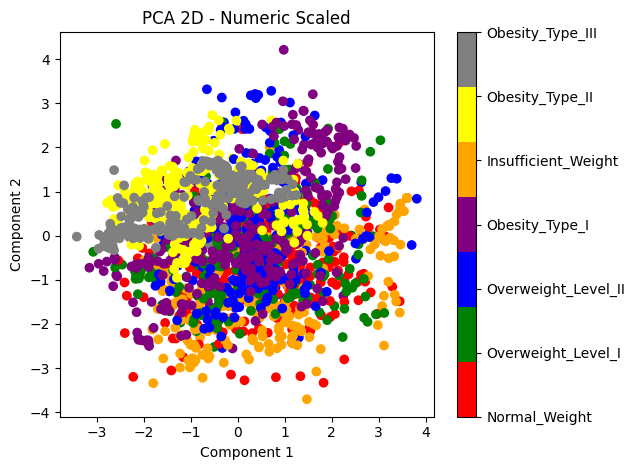

<Figure size 640x480 with 0 Axes>

In [36]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'gray']
assert len(label_indexes) == len(colors)

def plot_2d(title: str, data_to_plot: np.array, labels_for_plot: np.array):

    plt.scatter(data_to_plot[:, 0], data_to_plot[:, 1], c=labels_for_plot, cmap=matplotlib.colors.ListedColormap(colors))

    cb = plt.colorbar()
    loc = np.arange(0,len(colors), 1)
    cb.set_ticks(loc)

    cb.set_ticklabels(label_indexes)

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.tight_layout()
    plt.show()
    plt.clf()

plot_2d("PCA 2D - Numeric Scaled", numerical_pca_transformed_2d_scaled, label_dataset)

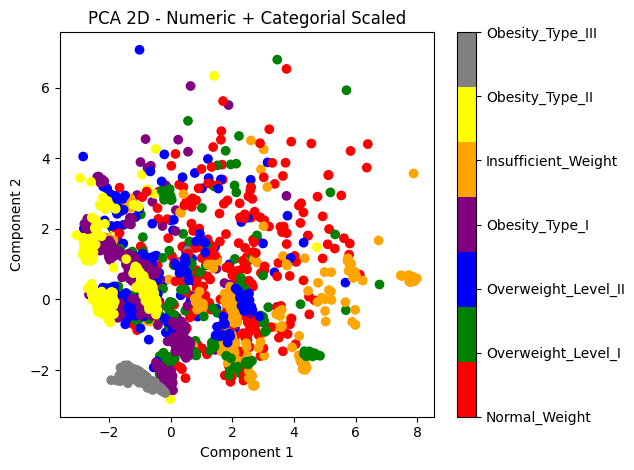

<Figure size 640x480 with 0 Axes>

In [37]:
plot_2d("PCA 2D - Numeric + Categorial Scaled", numerical_categorial_pca_transformed_2d_scaled, label_dataset)

In [38]:
data_to_plot_pd = pd.DataFrame(numerical_pca_transformed_3d_scaled, columns=["Component 1", "Component 2", "Component 3"])

data_to_plot_pd = pd.concat([data_to_plot_pd, pd.DataFrame(label_dataset_np_str, columns=["Label"])], axis=1, join="inner")

px.scatter_3d(data_to_plot_pd, x="Component 1", y="Component 2", z="Component 3", color="Label", title="PCA 3D - Numeric Scaled")

In [39]:
data_to_plot_pd = pd.DataFrame(numerical_categorial_pca_transformed_3d_scaled, columns=["Component 1", "Component 2", "Component 3"])

data_to_plot_pd = pd.concat([data_to_plot_pd, pd.DataFrame(label_dataset_np_str, columns=["Label"])], axis=1, join="inner")

px.scatter_3d(data_to_plot_pd, x="Component 1", y="Component 2", z="Component 3", color="Label", title="PCA 3D - Numeric + Categorial Scaled")

In [40]:
numerical_tsne_transformed_2d = TSNE(n_components=2).fit_transform(numeric_dataset)
numerical_tsne_transformed_2d_scaled = TSNE(n_components=2).fit_transform(numeric_dataset_scaled)
numerical_tsne_transformed_3d = TSNE(n_components=3).fit_transform(numeric_dataset)
numerical_tsne_transformed_3d_scaled = TSNE(n_components=3).fit_transform(numeric_dataset_scaled)


numerical_categorial_tsne_transformed_2d = TSNE(n_components=2).fit_transform(numerical_categorical_dataset)
numerical_categorial_tsne_transformed_2d_scaled = TSNE(n_components=2).fit_transform(numerical_categorical_dataset_scaled)
numerical_categorial_tsne_transformed_3d = TSNE(n_components=3).fit_transform(numerical_categorical_dataset)
numerical_categorial_tsne_transformed_3d_scaled = TSNE(n_components=3).fit_transform(numerical_categorical_dataset_scaled)

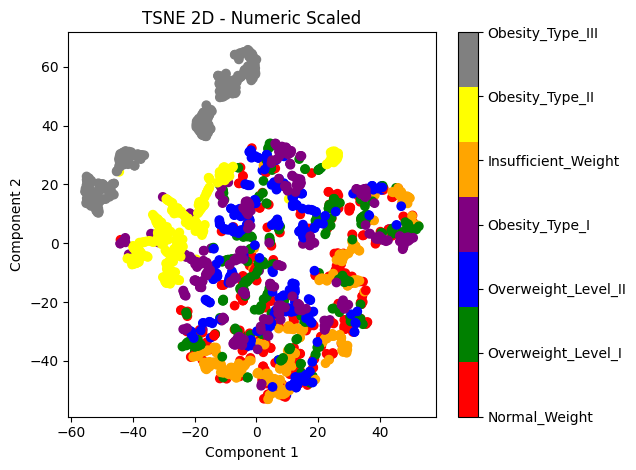

<Figure size 640x480 with 0 Axes>

In [41]:
plot_2d("TSNE 2D - Numeric Scaled", numerical_tsne_transformed_2d_scaled, label_dataset)

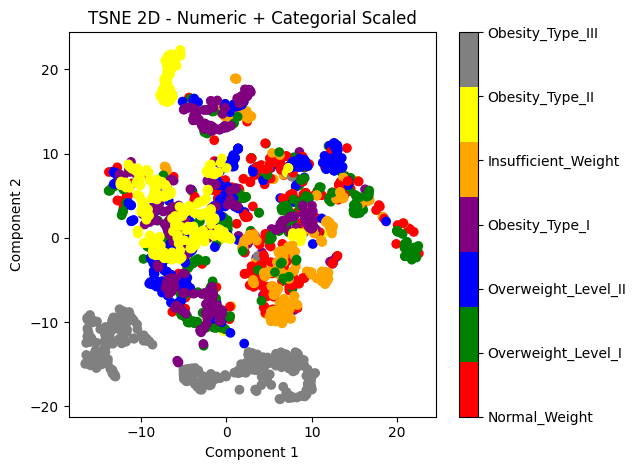

<Figure size 640x480 with 0 Axes>

In [42]:
plot_2d("TSNE 2D - Numeric + Categorial Scaled", numerical_categorial_tsne_transformed_3d_scaled, label_dataset)

In [43]:
data_to_plot_pd = pd.DataFrame(numerical_tsne_transformed_3d_scaled, columns=["Component 1", "Component 2", "Component 3"])

data_to_plot_pd = pd.concat([data_to_plot_pd, pd.DataFrame(label_dataset_np_str, columns=["Label"])], axis=1, join="inner")

px.scatter_3d(data_to_plot_pd, x="Component 1", y="Component 2", z="Component 3", color="Label", title="TSNE 3D - Numeric Scaled")

In [44]:
data_to_plot_pd = pd.DataFrame(numerical_categorial_tsne_transformed_3d_scaled, columns=["Component 1", "Component 2", "Component 3"])

data_to_plot_pd = pd.concat([data_to_plot_pd, pd.DataFrame(label_dataset_np_str, columns=["Label"])], axis=1, join="inner")

px.scatter_3d(data_to_plot_pd, x="Component 1", y="Component 2", z="Component 3", color="Label", title="TSNE 3D - Numeric + Categorial Scaled")

### 5. Projections using "Projection pursuit" methodologies

This will be run using more hackish ways. Results:

Result for an outlier-based guided tour:

![Result](./resources/animation1.gif)

Result for an latent-Dirichlet-allocation-based guided tour:

![Result](./resources/animation2.gif)


In [45]:
%%sh

R_LIBS_USER='~/.r' Rscript homework1.tourr.r

Converting input data to the required matrix format.


Value  1.340   0.1 % better 
Value  1.340   0.1 % better  - NEW BASIS


Using half_range 3.6


Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   -0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   -0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   -0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
Value  1.340   0.0 % better 
No better bases found after 25 tries.  Giving up.
Final projection: 
-0.685  0.606  
0.728  0.554  
0.021  0.571  


Inserting image 3 at 0.20s (100%)...
Encoding to gif... done!
Warning message:
In render_gif(normalised_data, tour_path = guided_tour(out_index),  :
  Note: only 3 frames generated, argument frames = 300 is ignored.


[1] "/home/mihai/Documents/Personal/Facultate/Master Anul 1/Data mining/Homework 1/Homework 1/resources/animation.gif"


### 6. Stacked histograms

Stacked histograms can help us with:
1. identifying inverse relationships
1. show pattern when dealing with categorical data
1. comparisons between groups
1. percentage distribution

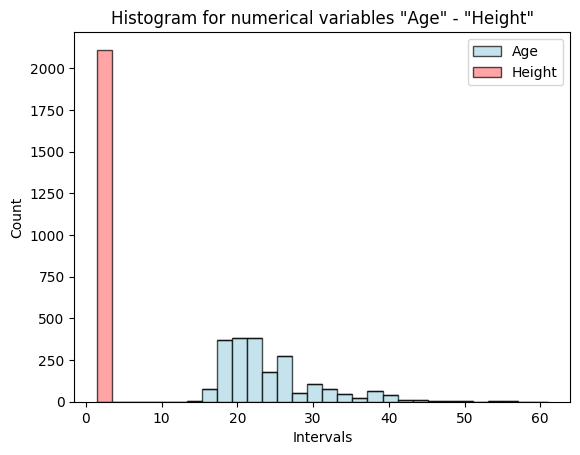

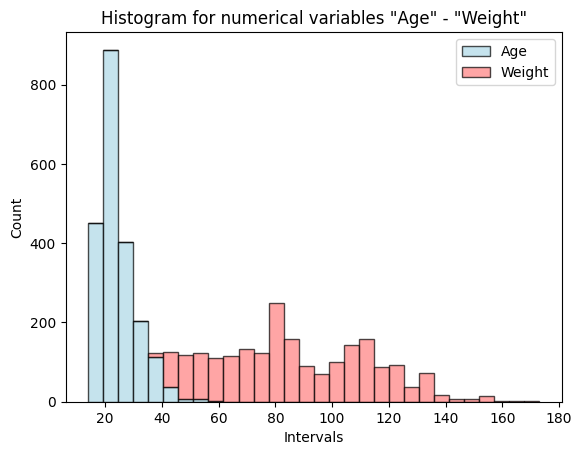

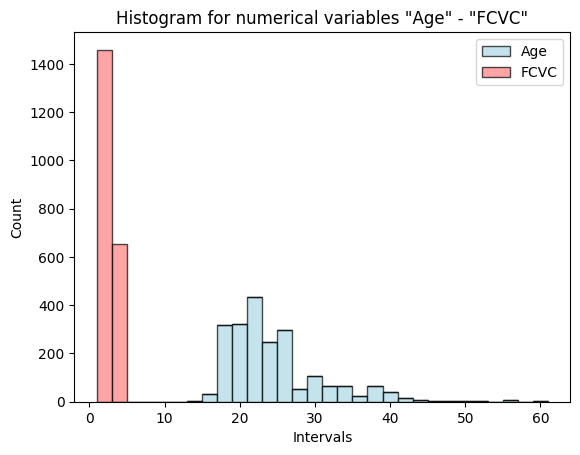

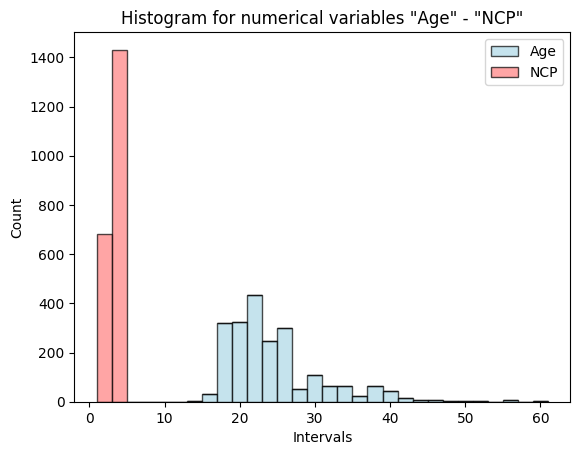

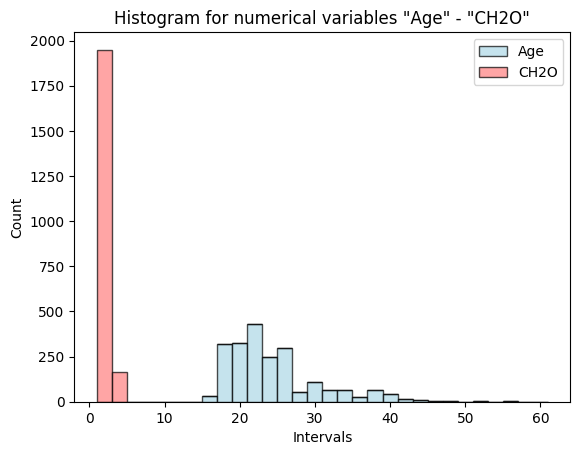

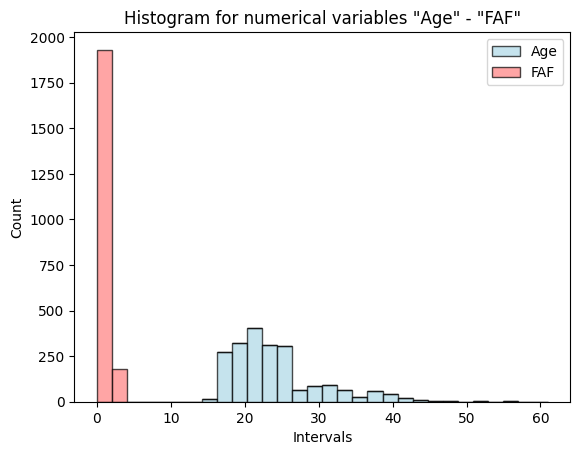

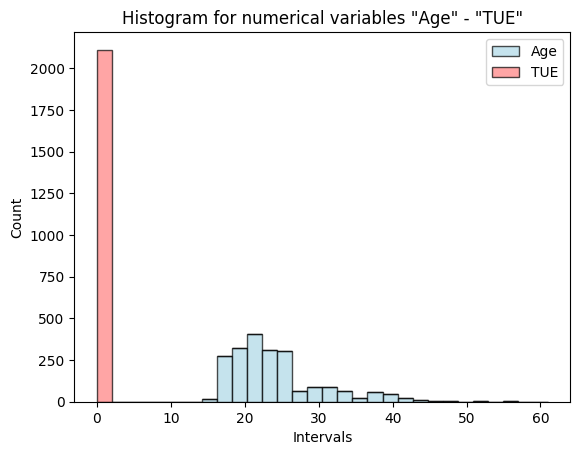

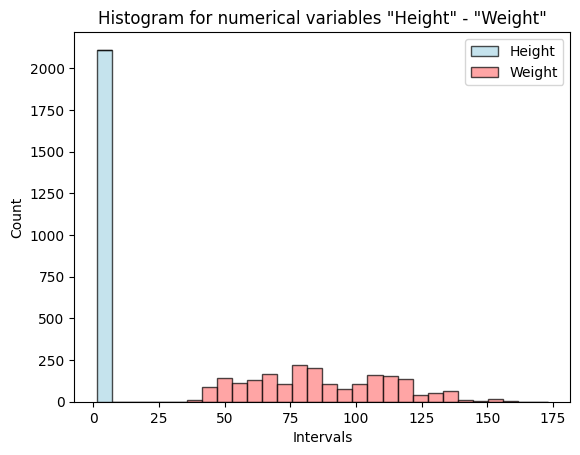

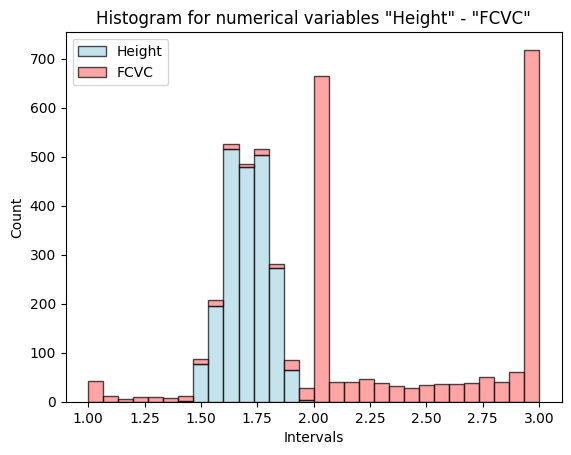

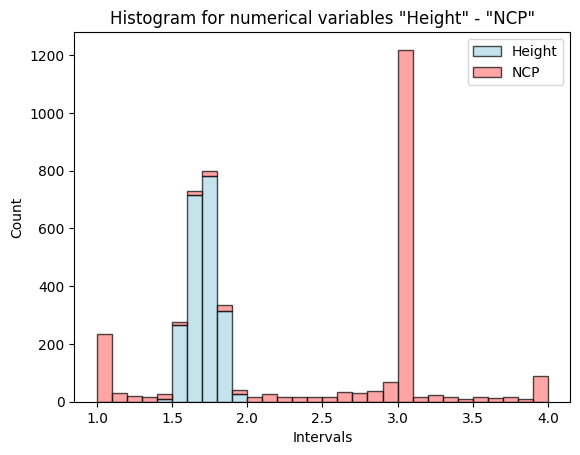

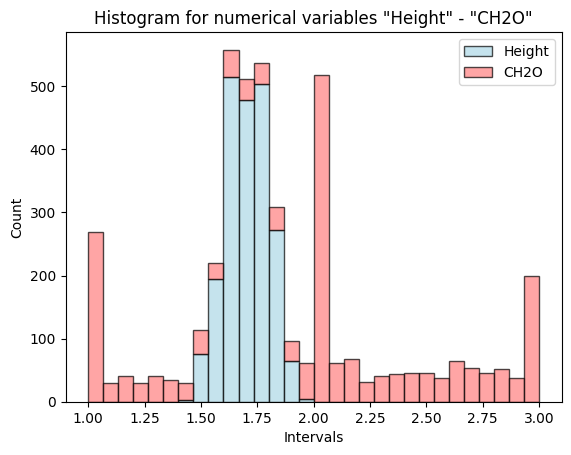

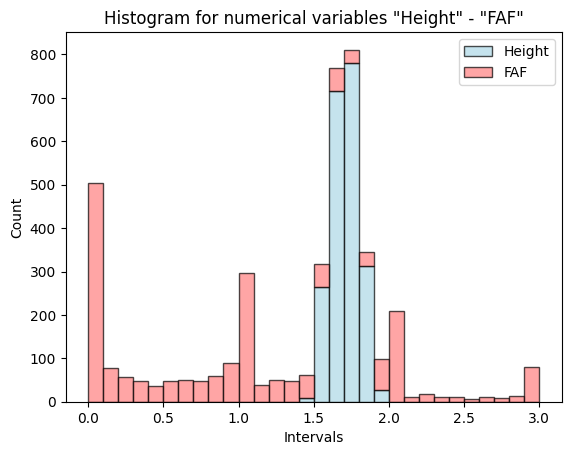

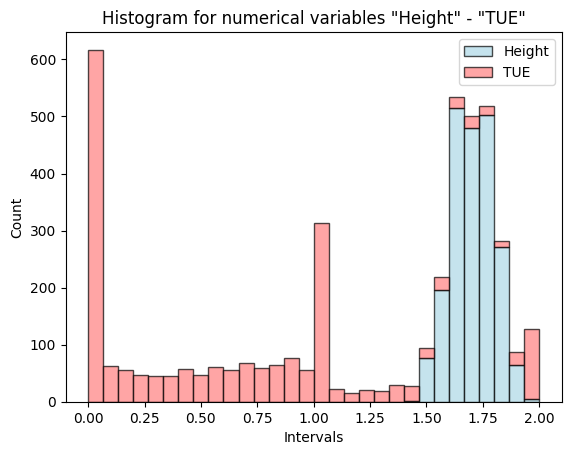

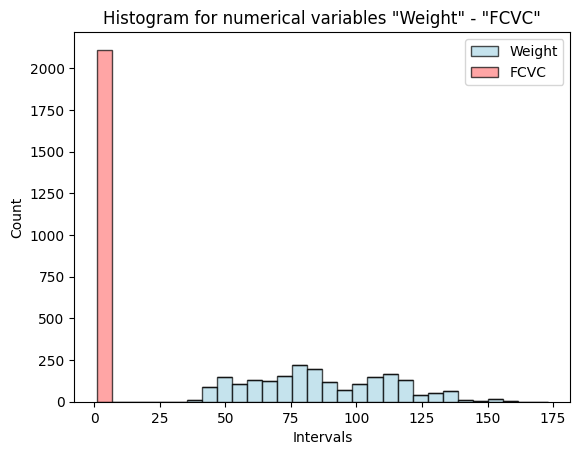

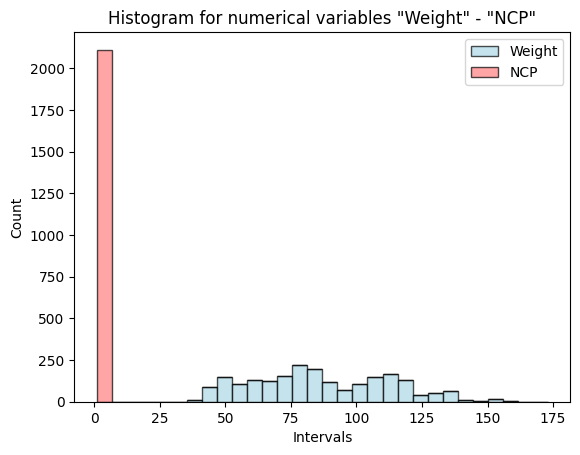

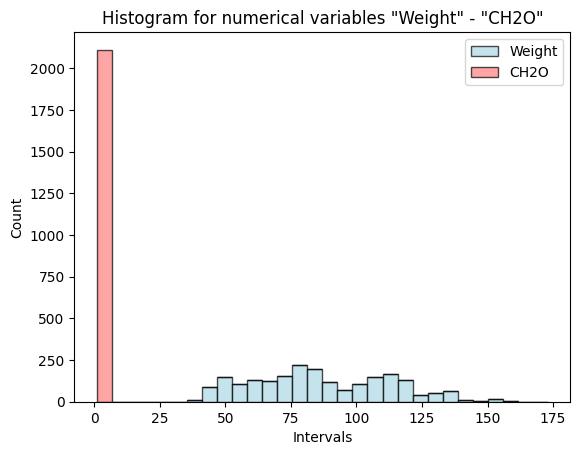

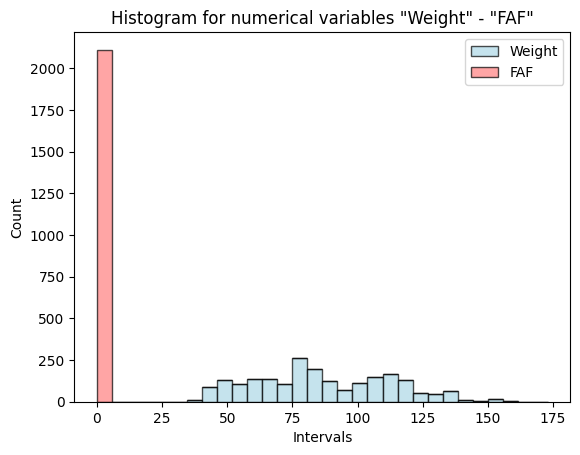

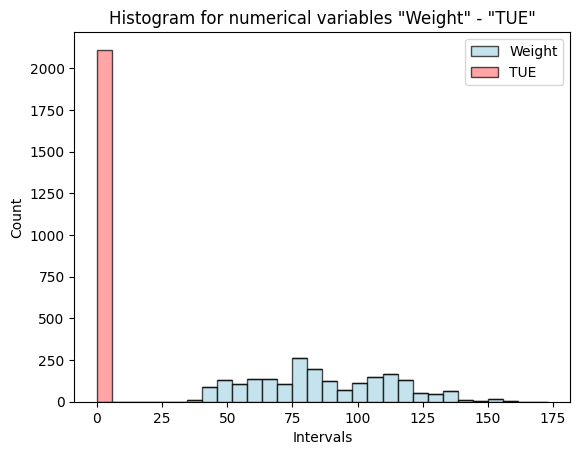

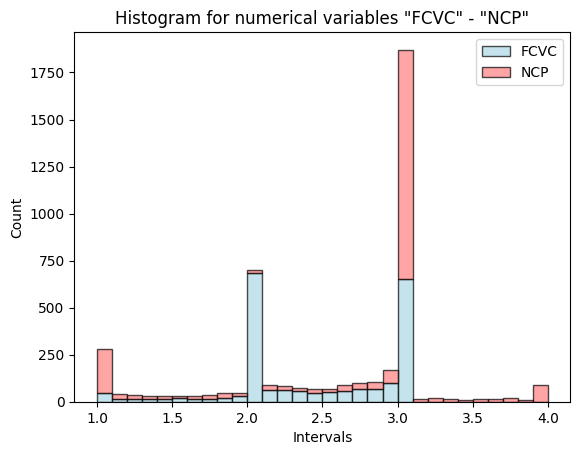

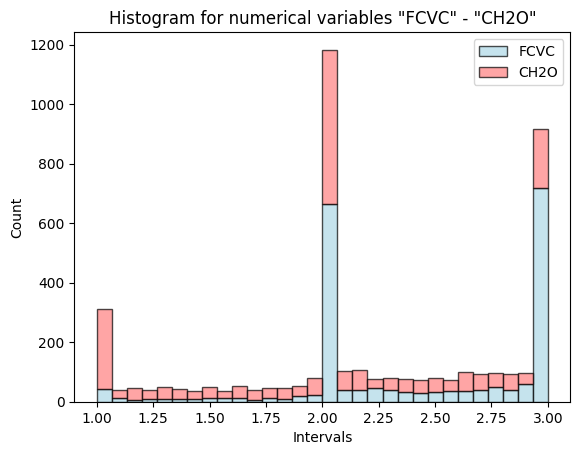

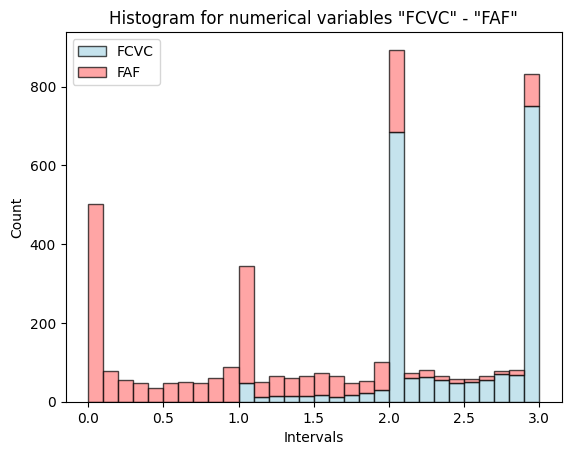

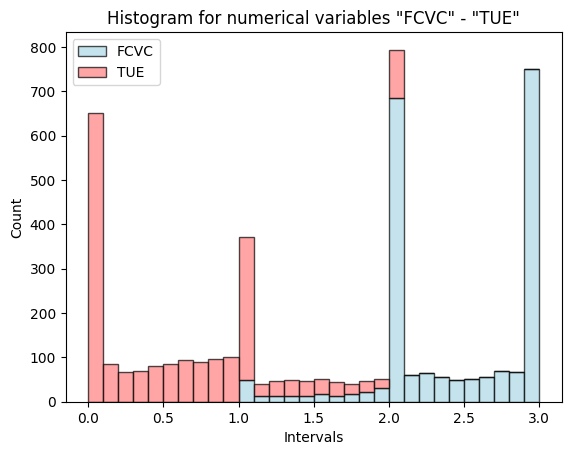

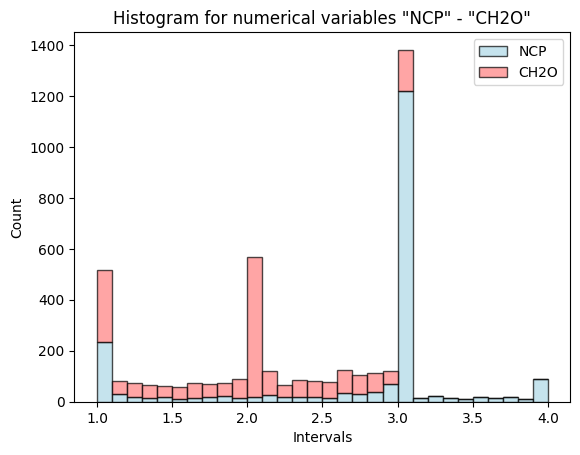

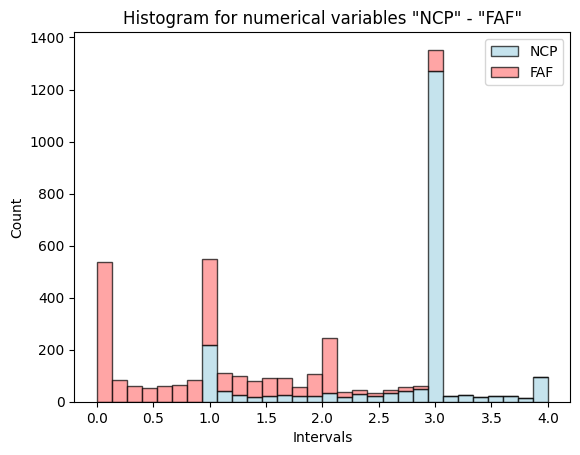

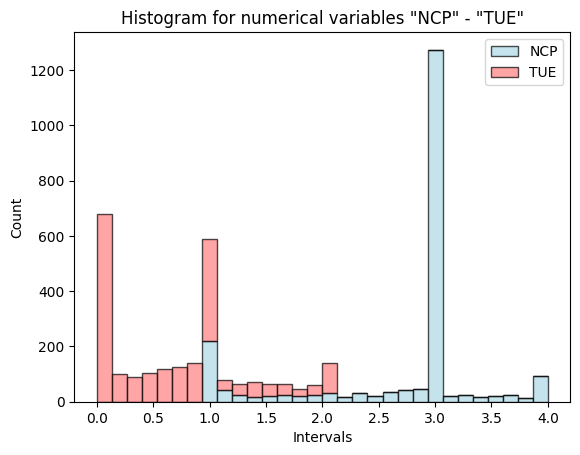

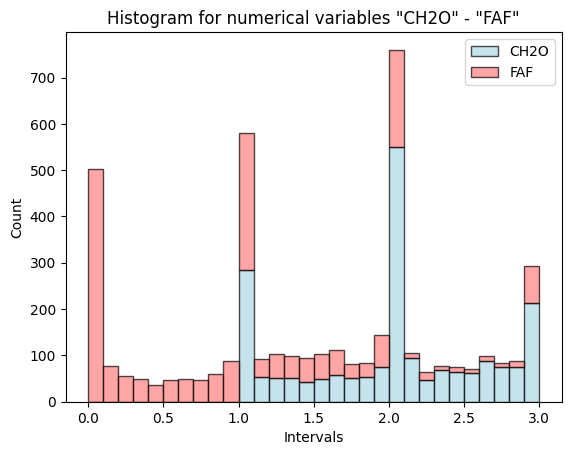

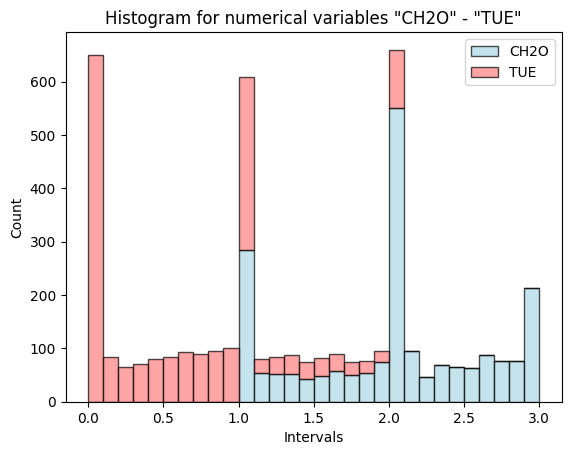

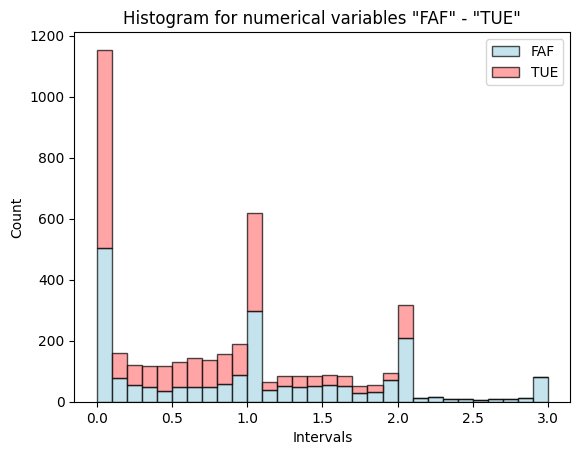

In [46]:
for attribute_a, attribute_b in DatasetManager.make_combinations(NUMERICAL_VARIABLES):
    [dataset_attribute_a, dataset_attribute_b] = DatasetManager.obj_list_to_dataseries(
        dataset_obj_list, [attribute_a, attribute_b]
    )

    plt.figure()
    plt.hist(
        [dataset_attribute_a, dataset_attribute_b],
        bins=30,
        color=["lightblue", "#FF7F7F"],
        edgecolor="black",
        alpha=0.7,
        stacked=True,
        label=[attribute_a, attribute_b],
    )
    plt.title(f'Histogram for numerical variables "{attribute_a}" - "{attribute_b}"')
    plt.xlabel("Intervals")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

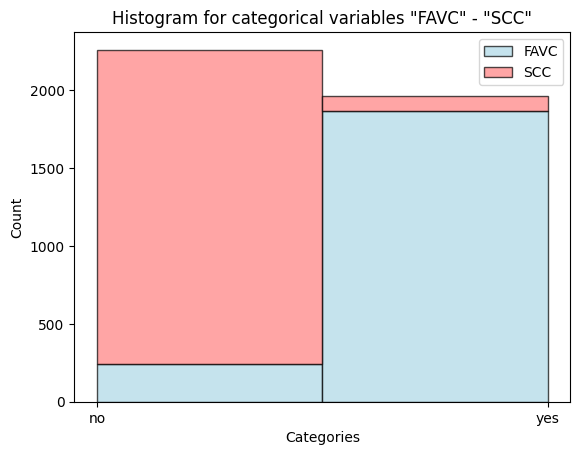

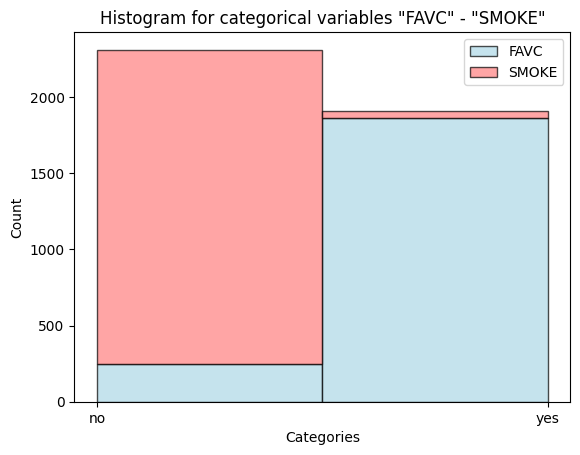

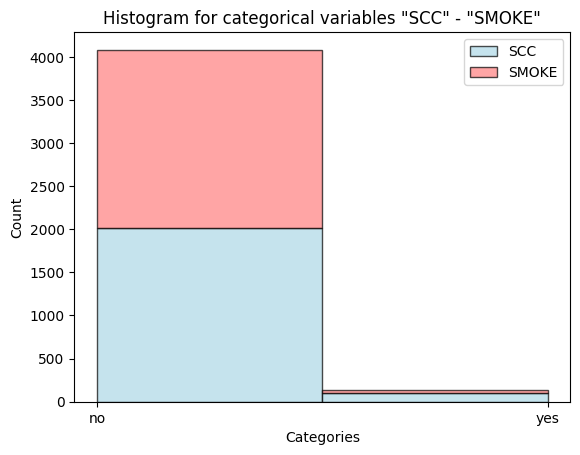

In [47]:
for attribute_a, attribute_b in DatasetManager.make_combinations(CATEGORICAL_VARIABLES):
    [dataset_attribute_a, dataset_attribute_b] = DatasetManager.obj_list_to_list(
        dataset_obj_list, [attribute_a, attribute_b]
    )

    frequencies_dataset_attribute_a = calculate_frequency_of_data_categorical(
        dataset_attribute_a
    )
    frequencies_dataset_attribute_b = calculate_frequency_of_data_categorical(
        dataset_attribute_b
    )

    frequencies_dataset_attribute_a_keys = [
        key for key in frequencies_dataset_attribute_a
    ]
    frequencies_dataset_attribute_a_values = [
        frequencies_dataset_attribute_a[key] for key in frequencies_dataset_attribute_a
    ]
    frequencies_dataset_attribute_b_keys = [
        key for key in frequencies_dataset_attribute_b
    ]
    frequencies_dataset_attribute_b_values = [
        frequencies_dataset_attribute_b[key] for key in frequencies_dataset_attribute_b
    ]

    if frequencies_dataset_attribute_a_keys != frequencies_dataset_attribute_b_keys:
        continue

    index = np.arange(len(frequencies_dataset_attribute_a_keys))

    plt.figure()
    plt.hist(
        [index, index],
        bins=len(frequencies_dataset_attribute_a_values),
        weights=[
            frequencies_dataset_attribute_a_values,
            frequencies_dataset_attribute_b_values,
        ],
        color=["lightblue", "#FF7F7F"],
        edgecolor="black",
        alpha=0.7,
        align="mid",
        stacked=True,
        label=[attribute_a, attribute_b],
    )
    plt.title(f'Histogram for categorical variables "{attribute_a}" - "{attribute_b}"')
    plt.xlabel("Categories")
    plt.ylabel("Count")
    plt.xticks(index, frequencies_dataset_attribute_a_keys)
    plt.legend()
    plt.show()

### 7. Conditional Boxplots

Conditional Boxplots can help us with:
1. identifying relationships between numerical and categorical variables
1. explains variance of numerical variable

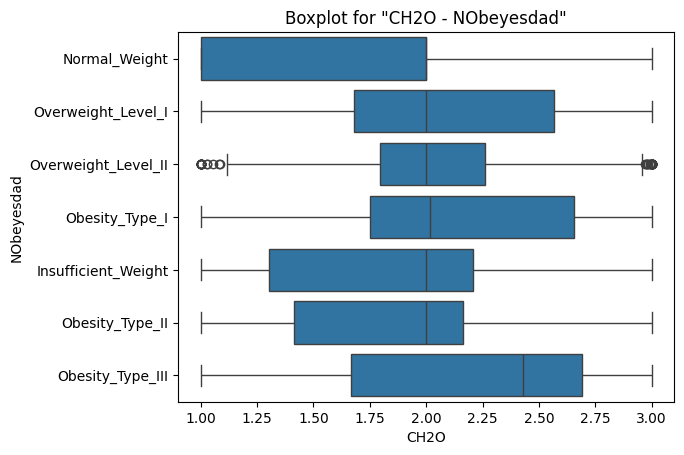

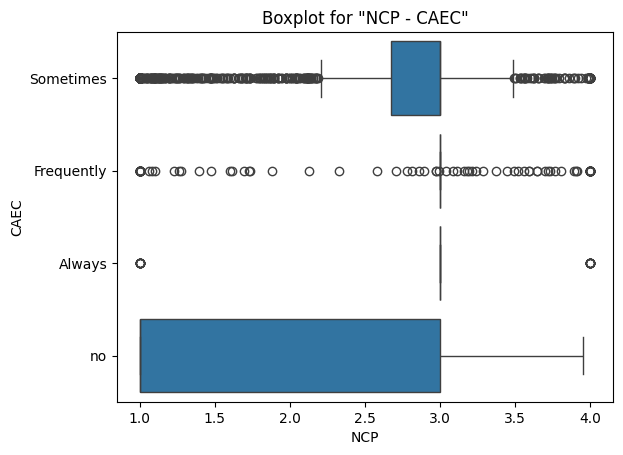

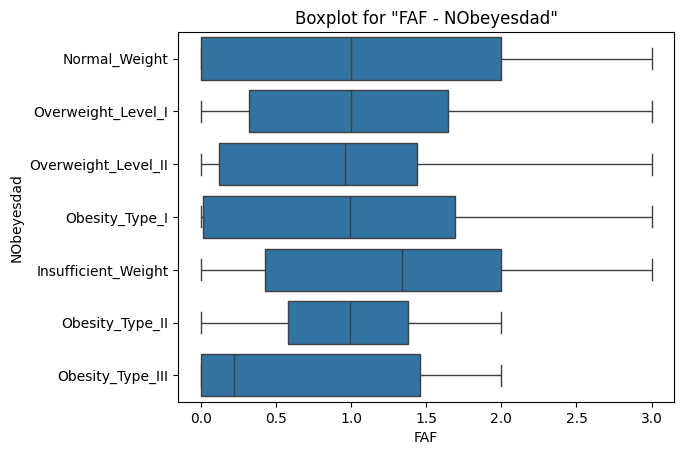

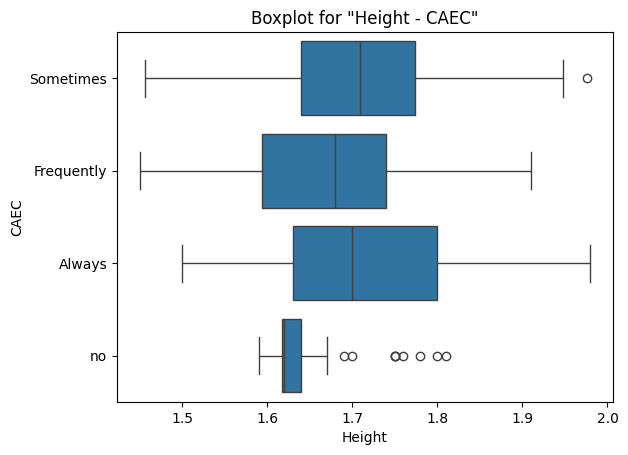

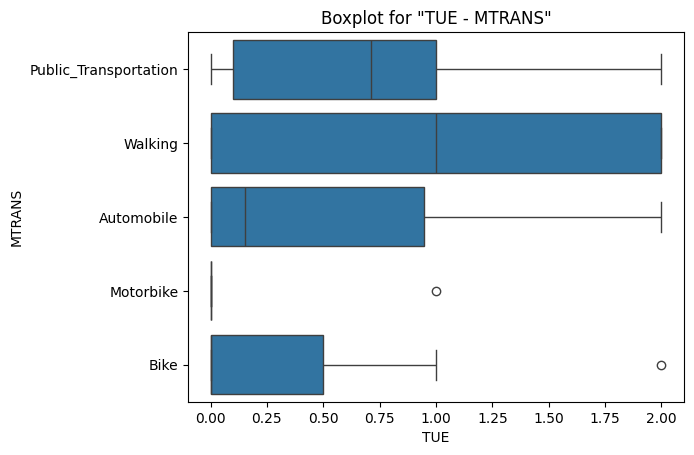

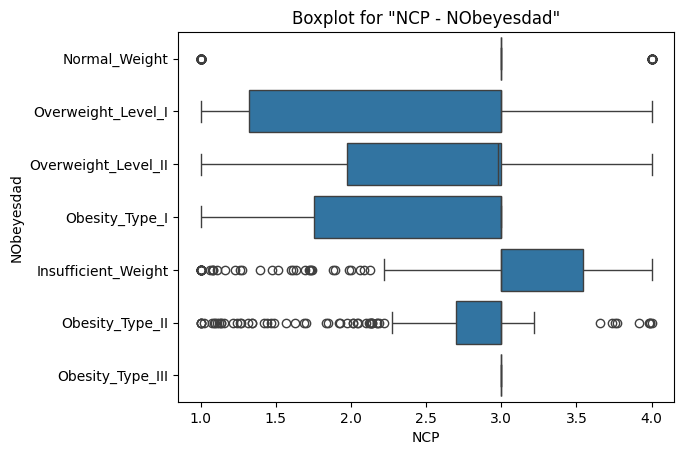

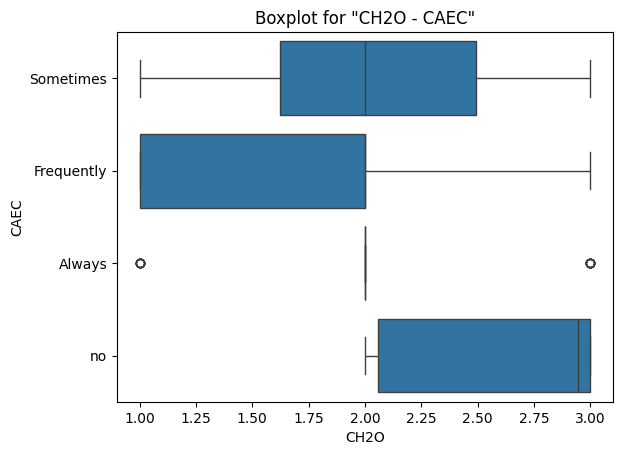

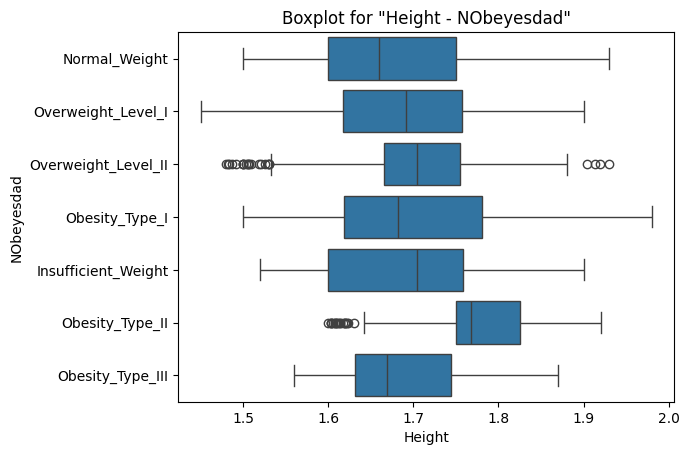

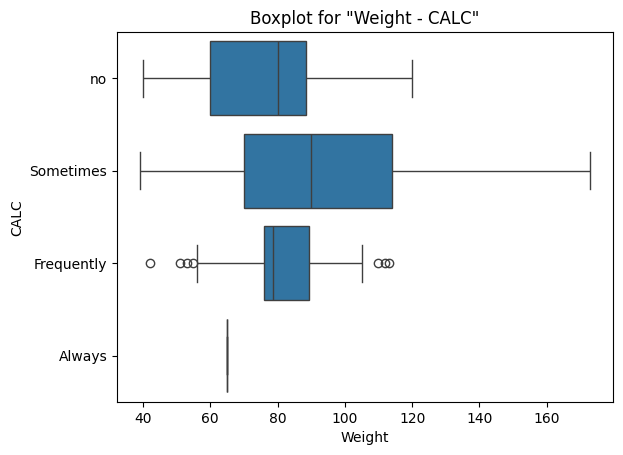

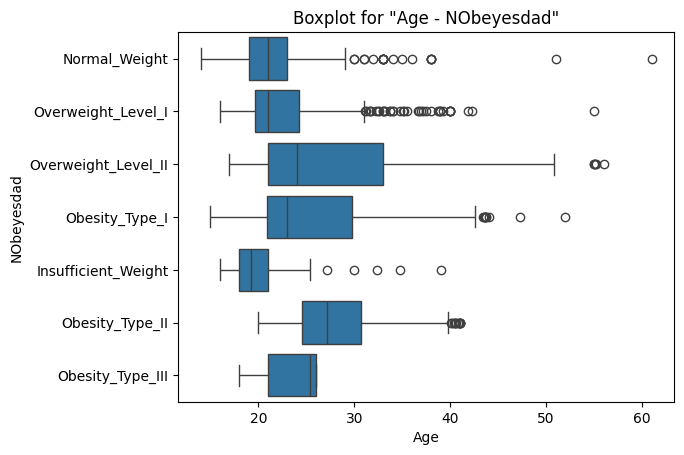

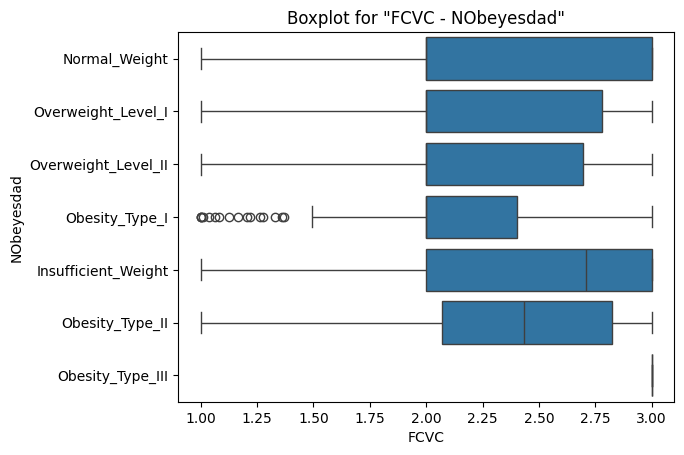

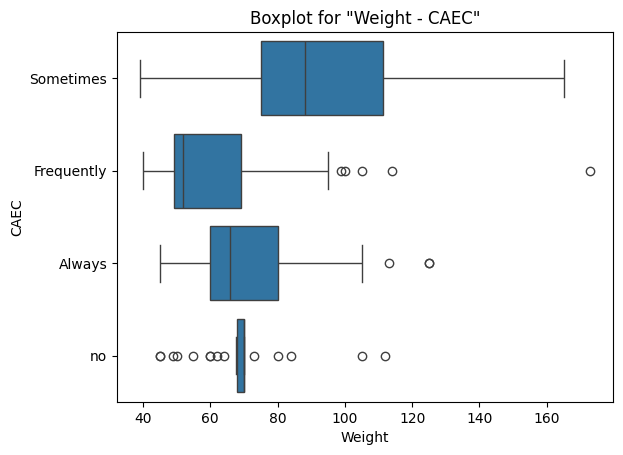

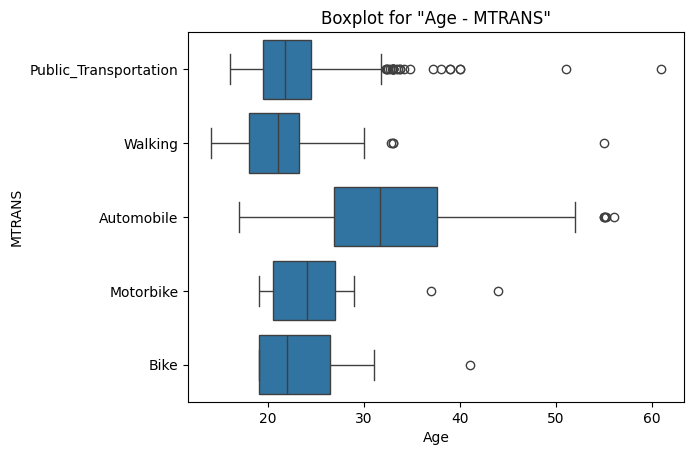

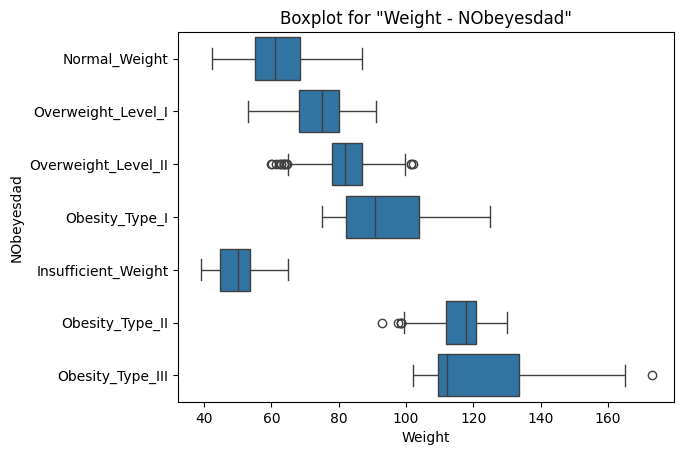

<Figure size 640x480 with 0 Axes>

In [48]:
for (numerical_var, categorical_var, _) in best_anova_test:

    numerical_var_data = DatasetManager.obj_list_to_np_array_numeric(dataset_obj_list, [numerical_var])

    categorical_var_data = DatasetManager.obj_list_to_np_array(dataset_obj_list, [categorical_var])

    df = pd.DataFrame(data=np.hstack((numerical_var_data, categorical_var_data)), columns=[numerical_var, categorical_var])

    df[numerical_var] = df[numerical_var].apply(pd.to_numeric)

    ax = sns.boxplot(data=df, x=numerical_var, y=categorical_var)
    plt.title(f'Boxplot for "{numerical_var} - {categorical_var}"')
    plt.show()
    plt.clf()


### 8. Combined Scatterplots

Combined Scatterplots can help us with:
1. visualising relationships between 2 numerical variables
1. see if the data is separable using just those 2 numerical variables

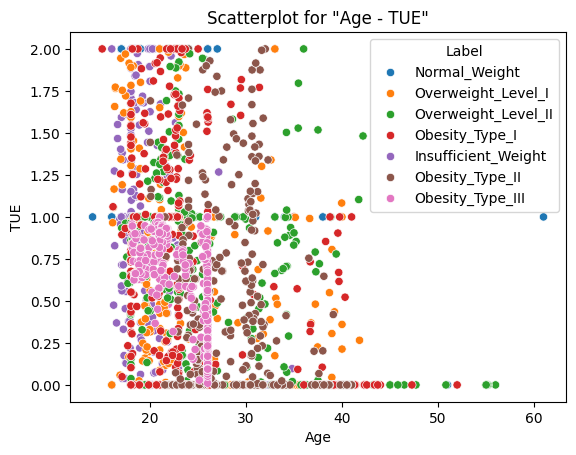

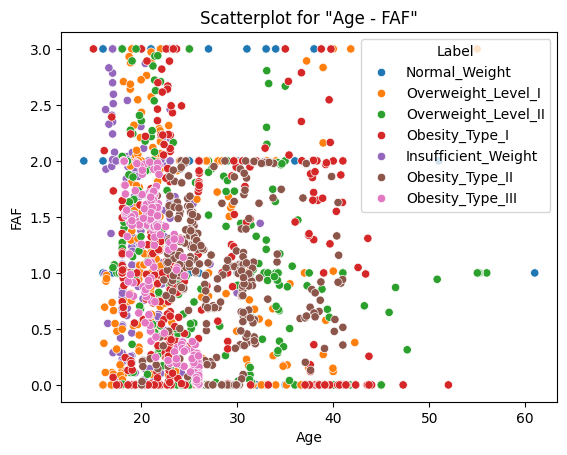

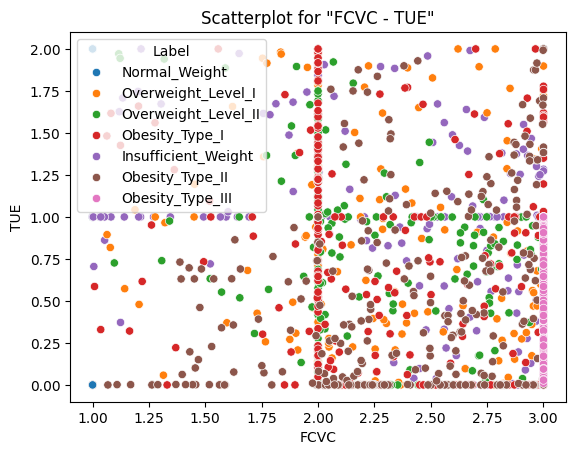

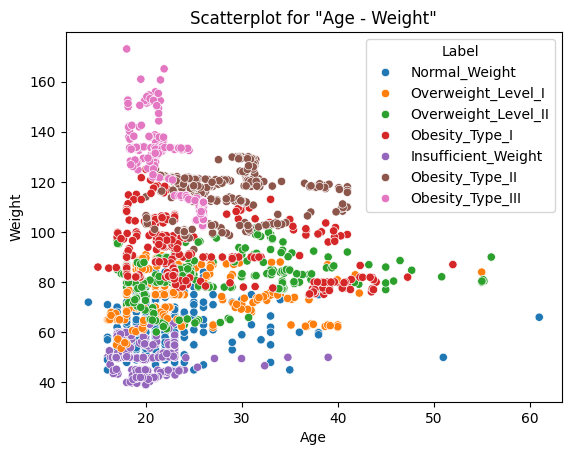

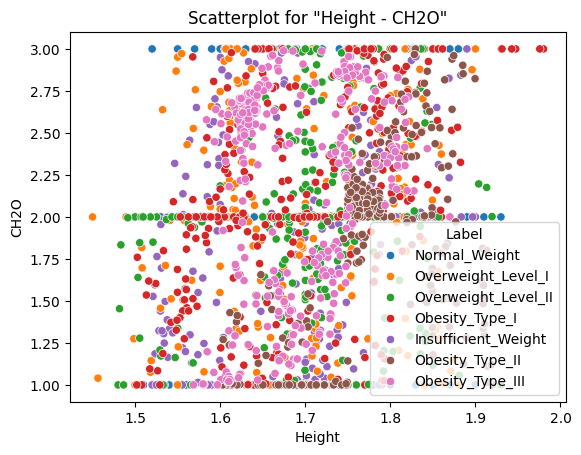

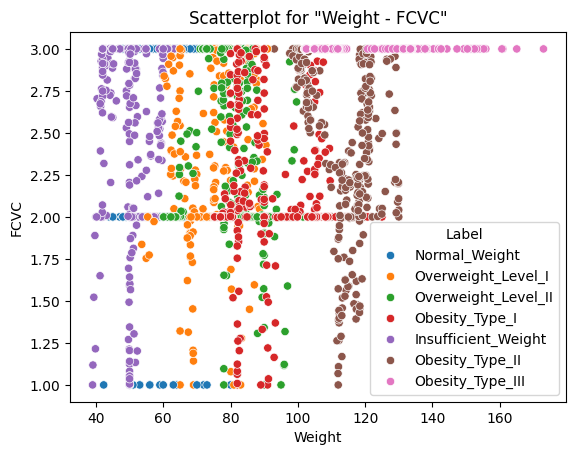

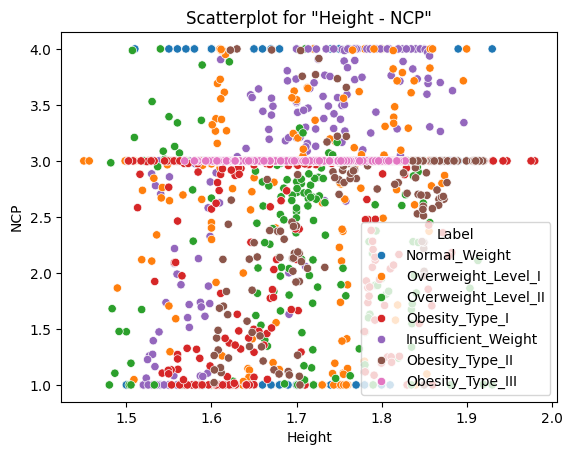

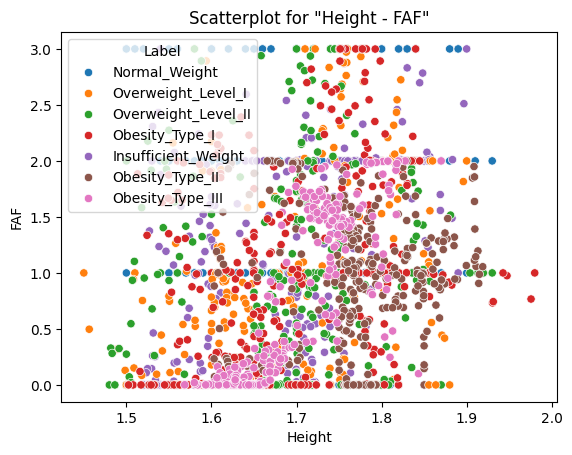

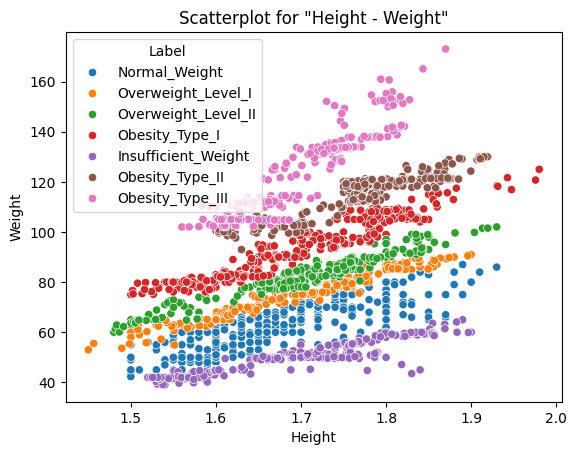

<Figure size 640x480 with 0 Axes>

In [49]:
label_dataset_np_str = DatasetManager.obj_list_to_np_array(dataset_obj_list, [LABEL_VARIABLE])

for (numerical_var_lh, numerical_var_rh, _) in best_numerical_correlations:
    numerical_var_data_lh = DatasetManager.obj_list_to_np_array_numeric(dataset_obj_list, [numerical_var_lh])

    categorical_var_data_rh = DatasetManager.obj_list_to_np_array_numeric(dataset_obj_list, [numerical_var_rh])

    df = pd.DataFrame(data=np.hstack((numerical_var_data_lh, categorical_var_data_rh)), columns=[numerical_var_lh, numerical_var_rh])

    df = pd.concat([df, pd.DataFrame(label_dataset_np_str, columns=["Label"])], axis=1, join="inner")

    sns.scatterplot(data=df, x=numerical_var_lh, y=numerical_var_rh, hue="Label")

    plt.title(f'Scatterplot for "{numerical_var_lh} - {numerical_var_rh}"')
    plt.show()
    plt.clf()


### 9. Corrgrams

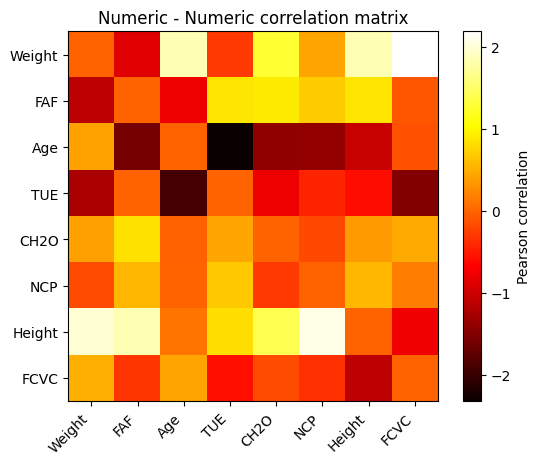

In [51]:
def plot_variable_correlation(correlation_title: str, correlation_bar: str, correlation_map: dict):

    variables = list(set([var[0] for var in correlation_map] + [var[1] for var in correlation_map]))

    result_matrix = np.full(shape=(len(variables), len(variables)), fill_value=0, dtype=np.float32)

    for it_ in range(len(variables)):
        for jt_ in range(len(variables)):
            if it_ == jt_:
                continue

            it_var = variables[it_]
            jt_var = variables[jt_]

            if (it_var, jt_var) in correlation_map:
                key = (it_var, jt_var)
            else:
                key = (jt_var, it_var)

            if key in correlation_map:
                result_matrix[it_, jt_] = correlation_map[key]
            else:
                result_matrix[it_, jt_] = 0

    result_matrix = StandardScaler().fit_transform(result_matrix)

    for it_ in range(len(variables)):
        result_matrix[it_, it_] = 0

    plt.figure()
    plt.imshow(result_matrix, cmap="hot")
    plt.colorbar(label=correlation_bar, cmap="hot")
    plt.title(correlation_title)
    plt.xticks(range(len(variables)), variables, rotation=45, ha='right')
    plt.yticks(range(len(variables)), variables)
    plt.show()

plot_variable_correlation("Numeric - Numeric correlation matrix", "Pearson correlation",numeric_numeric_correlation_indexes)

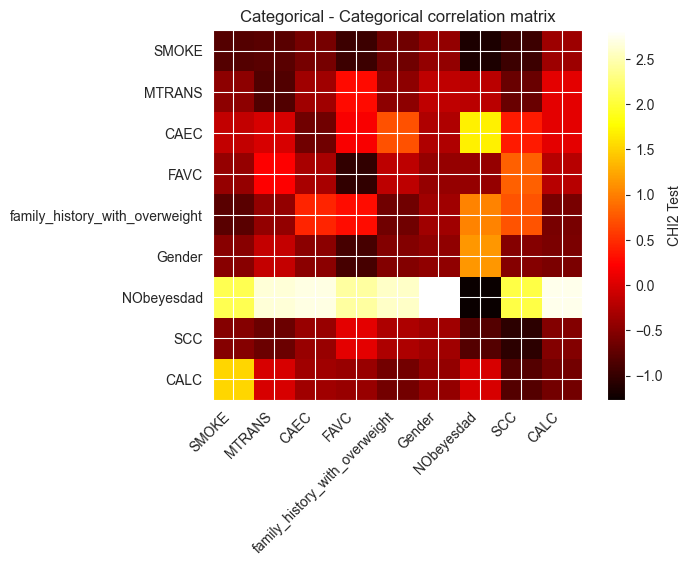

In [ ]:
plot_variable_correlation("Categorical - Categorical correlation matrix", "CHI2 Test",categorial_categorial_correlation_indexes)

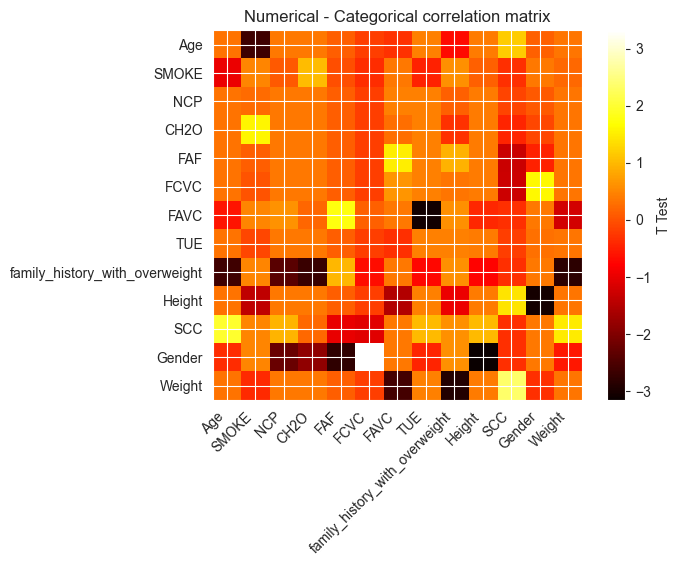

In [ ]:
plot_variable_correlation("Numerical - Categorical correlation matrix", "T Test",categorial_numeric_t_correlation_indexes)


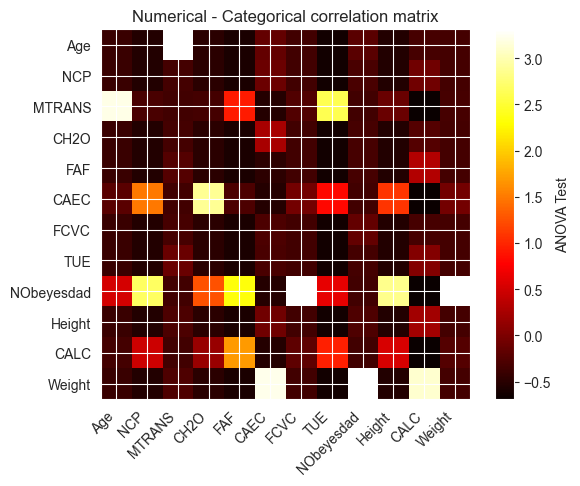

In [ ]:
plot_variable_correlation("Numerical - Categorical correlation matrix", "ANOVA Test",categorial_numeric_anova_correlation_indexes)
